## TODO


- Add more evaluation variables
    - average cost-to-goal
- Get and plot optimal values
    - q values for each action and k_g-lambda combination (horizon?)
        - from it optimal action can be obtained
    - cost-to-goal for k_g-kambda combination (and horizon?)
    
    

In [1]:
import itertools
import json
import os
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import seaborn as sns

import common

data_paths = ["../output/tireworld"]
data_files = [os.path.join(data_path, f) for data_path in data_paths for f in os.listdir(data_path) if not os.path.isdir(os.path.join(data_path, f))]

plt.style.use('default')

parameters = {
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'legend.title_fontsize': 18,
}
plt.rcParams.update(parameters)

In [2]:
data_files = common.get_data_files_from_paths(data_paths)
print(f"Found {len(data_files)} data files")

Found 1874 data files


In [3]:
def read_json(file_name):
    with open(file_name) as json_data:
        return json.load(json_data)        

In [4]:
def read_file_data(file_name):
    heuristics_spl = file_name.split('/')[0].split('_')
    return {
        **read_json(file_name),
        'output_file_name': file_name,
    }

In [5]:
info_runs = [read_file_data(file_name) for file_name in data_files]
len(info_runs)

1874

In [6]:
runs_by_envs = {}
for run in info_runs:
    if 'env' not in run:
        run['env'] = 'PDDLEnvTireworld-v0'
    env = run['env']
    if env not in runs_by_envs:
        runs_by_envs[env] = []
    runs_by_envs[env].append(run)


In [7]:
set([run['args']['lamb'] for run in runs_by_envs['PDDLEnvTireworld-v0']])

{-0.3, -0.25, -0.2, -0.1, 0.25}

# Optimal values

In [8]:
# optimal values

optimal_vals = {
    # key: problem index
    1: [
        (-0.3, 1e-7, ("movecar(l-2-1:location)", 0.04743879500927663, 0.5)),
        (-0.25, 1e-7, ("movecar(l-2-1:location)", 0.06980998532003882, 0.5)),
        (-0.2, 1e-7, ("movecar(l-2-1:location)", 0.10382409406696208, 1)),
        #
        (-0.3, 1e-2, ("movecar(l-2-1:location)", 0.052438795009276624, 0.5)),
        (-0.25, 1e-2, ("movecar(l-2-1:location)", 0.07480998532003882, 0.5)),
        (-0.2, 1e-2, ("movecar(l-2-1:location)", 0.11382399406696207, 1)),
        #
        (-0.3, 1, ("movecar(l-2-1:location)", 1.0343365960744917, 1)),
        (-0.25, 1, ("movecar(l-2-1:location)", 1.0595788684035934, 1)),
        (-0.2, 1, ("movecar(l-2-1:location)", 1.103823994066962, 1)),
    ],
}

def get_vals_from_lamb_and_kg(lamb, k_g, prob_i, optimal_vals):
    
    for val in optimal_vals[prob_i]:
        if len(val) < 3:
            raise ValueError("wrong length of value")
        if val[0] == lamb and val[1] == k_g:
            return val[2]
    
    # no value was found
    raise ValueError("no value was found")

def get_vals_by_lamb(k_g, prob_i, optimal_vals):
    lambs = set({val[0] for val in optimal_vals[prob_i]})
    optimal = {}
    for lamb in lambs:
        optimal[lamb] = get_vals_from_lamb_and_kg(lamb, k_g, prob_i, optimal_vals)
        
    return optimal

def get_vals_by_kg(lamb, prob_i, optimal_vals):
    kgs = set({val[1] for val in optimal_vals[prob_i]})
    optimal = {}
    for k_g in kgs:
        optimal[k_g] = get_vals_from_lamb_and_kg(lamb, k_g, prob_i, optimal_vals)
        
    return optimal

def get_res_by_kg(res_i, lamb, prob_i, optimal_vals):
    return {k_g: res[res_i] for k_g, res in get_vals_by_kg(lamb, prob_i, optimal_vals).items()}

def get_res_by_lamb(res_i, k_g, prob_i, optimal_vals):
    return {lamb: res[res_i] for lamb, res in get_vals_by_lamb(k_g, prob_i, optimal_vals).items()}

optimal_actions_by_lamb_tireworld_1_1e7 = get_res_by_lamb(0, 1e-7, 1, optimal_vals)
optimal_qs_by_lamb_tireworld_1_1e7 = get_res_by_lamb(1, 1e-7, 1, optimal_vals)
optimal_probs_by_lamb_tireworld_1_1e7 = get_res_by_lamb(2, 1e-7, 1, optimal_vals)

optimal_actions_by_kg_tireworld_1_03 = get_res_by_kg(0, -0.3, 1, optimal_vals)
optimal_qs_by_kg_tireworld_1_03 = get_res_by_kg(1, -0.3, 1, optimal_vals)
optimal_probs_by_kg_tireworld_1_03 = get_res_by_kg(2, -0.3, 1, optimal_vals)

print(
    optimal_actions_by_lamb_tireworld_1_1e7, '\n',
    optimal_qs_by_lamb_tireworld_1_1e7, '\n',
    optimal_probs_by_lamb_tireworld_1_1e7, '\n',
    optimal_actions_by_kg_tireworld_1_03, '\n',
    optimal_qs_by_kg_tireworld_1_03, '\n',
    optimal_probs_by_kg_tireworld_1_03
)

{-0.3: 'movecar(l-2-1:location)', -0.25: 'movecar(l-2-1:location)', -0.2: 'movecar(l-2-1:location)'} 
 {-0.3: 0.04743879500927663, -0.25: 0.06980998532003882, -0.2: 0.10382409406696208} 
 {-0.3: 0.5, -0.25: 0.5, -0.2: 1} 
 {1e-07: 'movecar(l-2-1:location)', 0.01: 'movecar(l-2-1:location)', 1: 'movecar(l-2-1:location)'} 
 {1e-07: 0.04743879500927663, 0.01: 0.052438795009276624, 1: 1.0343365960744917} 
 {1e-07: 0.5, 0.01: 0.5, 1: 1}


In [9]:
def prop_via_path(path, dic):
    val = dic
    for key in path.split('.'):
        val = val[key]
    return val

In [10]:
def filter_runs_by_prop(prop, val, runs):
    return [run for run in runs if prop_via_path(prop, run) == val]

def filter_runs_by_props(runs, *pairs):
    res = runs
    for prop, val in pairs:
        res = filter_runs_by_prop(prop, val, res)
    return res

In [11]:
def check_for_intersections(run_collection):
    sets = []
    for runs in run_collection:
        sets.append(set({x['output_file_name'] for x in runs}))

    for set1, set2 in itertools.combinations(sets, 2):
        if len(set1.intersection(set2)) > 0:
            print("detected intersection!")

In [12]:
# gets x and y axis data to plot
def get_plot_data(x_var_path, y_var_paths, source):
    i_source_sorted = np.argsort([prop_via_path(x_var_path, run) for run in source])
    xs = np.array([prop_via_path(x_var_path, run) for run in source])[i_source_sorted]
    
    yss = []
    for y_path, plot_type in y_var_paths:
        if plot_type == "line":
            yss.append(
                (
                    np.array([np.mean(prop_via_path(y_path, run)) for run in source])[i_source_sorted],
                    np.array([np.std(prop_via_path(y_path, run)) for run in source])[i_source_sorted]
                )
            )
        if plot_type == "bar":
            y = np.array([prop_via_path(y_path, run) for run in source])[i_source_sorted]
            counters = list(map(Counter, y))
            keys = counters[0].keys()
            yss.append([[c[key] for c in counters] for key in keys])         
    return xs, yss

    
# gets data from fixed and free variable for single plot line
def get_plot_data_by_fixed_var(fixed_var_path, fixed_var_val, x_var_path, y_var_paths, source):
    fixed_var_filter = (fixed_var_path, fixed_var_val)
    source_by_x_var = filter_runs_by_props(source, fixed_var_filter)
    source_by_x_var_xs, source_by_x_var_yss = get_plot_data(x_var_path, y_var_paths, source_by_x_var)
    
    return source_by_x_var_xs, source_by_x_var_yss

# gets data from fixed and free variable for multiple plot lines
def get_plot_data_by_fixed_var_from_sources(fixed_var_path, fixed_var_val, x_var_path, y_var_paths, sources):
    res = []
    for source in sources:
        source_by_xvar_xs, source_by_xvar_yss = get_plot_data_by_fixed_var(
            fixed_var_path, fixed_var_val, x_var_path, y_var_paths, source
        )
        res.append((source_by_xvar_xs, source_by_xvar_yss))
        
    return res

# plots a single plot from sources
def plot_from_sources(sources, labels, title, ax, plot_type="line", bar_width=0.25):
    ax.set_title(title)
    for i, source in enumerate(sources):
        if plot_type == "line":
            ax.plot(source[0], source[1], label=labels[i])
            if len(source) > 2:
                ax.fill_between(source[0], source[1] - source[2], source[1] + source[2], alpha=0.1)
        if plot_type == "bar":
#             print("plot_from_sources bar!", source[1])
            plot_bars(source[0], source[1], labels[i], ax=ax, bar_width=bar_width)
    ax.legend()
    
# creates a figure and makes mutiple plots from sets of sources
def plot_multiple_from_plot_data_source_sets(source_sets, titles, labels, shape, figsize, bar_width=0.25, plot_type="line"):
    fig, axs = plt.subplots(shape[0], shape[1], figsize=figsize)
    axs = axs.reshape(*shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            plot_from_sources(source_sets[i][j], labels, titles[i][j], axs[i][j], bar_width=bar_width, plot_type=plot_type)


In [13]:
def plot_bars(xs, yss, labels, ax=None, bar_width=0.25):
#     print("plot_bars ->", xs, yss, labels, ax)
    
    if ax is None:
        fig, ax = plt.subplots(figsize =(12, 8))
    
    x_pos = range(len(yss[0]))
    offset = x_pos
    for ys, label in zip(yss, labels):
        x_ = [x + bar_width for x in offset]
#         print("ax.bar ", x_, ys, label)
        ax.bar(x_, ys, width = bar_width,
                edgecolor ='grey', label=label)
        offset = x_
    ax.set_xticks([r + (len(yss) / 2 + 0.5) * bar_width for r in x_pos], xs)
    ax.legend()

In [16]:
def flatten(l):
    return [x for _l in l for x in _l]

def get_plot_source_from_plot_data(plot_data):
    res = []
    for i in range(len(plot_data[0][1])):
        res.append([])
        for data_list in plot_data:
            xs, single_plot_data = data_list[0], data_list[1]
            res[i].append((xs, *single_plot_data[i]))
    return res

def parse_best_actions_plot_source(sources_best_actions):
    _sources_best_actions = list(zip(*sources_best_actions))
    return [(_sources_best_actions[0][0], flatten(_sources_best_actions[1:]))]


# Evaluate heuristics

In [14]:
# Parâmetros:
#       base_params -> parâmetros fixados
#       parâmetros das linhas -> o que vai ser variado em cada linha plotada no gráfico
#       variável fixa - cada plot representa um valor fixado dessa variável - ex: lambda
#       parâmetro x que varia -> o que vai aparecer no eixo x dos plots - ex: k_g
#       parâmetros de cada conjunto de plots - o eixo y do que vai ser mostrado nos plots.
#         Cada um é um conjunto de plots diferentes

In [15]:
# Evaluate heuristics

base_params = [("args.problem_index", 1), ("args.n_rollouts", 1000), ("args.h_init_count", 20), ("args.norm_exploration_constant", True), ("args.horizon", 100)]

h1_runs = filter_runs_by_props(info_runs, ("args.h_p", "h1"), ("args.h_u", "h1"), *base_params)
h1p_runs = filter_runs_by_props(info_runs, ("args.h_p", "h1"), ("args.h_u", "shortest_path"), *base_params)
h1u_runs = filter_runs_by_props(info_runs, ("args.h_p", "handcrafted"), ("args.h_u", "h1"), *base_params)
h_runs = filter_runs_by_props(info_runs, ("args.h_p", "handcrafted"), ("args.h_u", "shortest_path"), *base_params)

# check for intersection - shouldn't have any
# ----------------------------------------------------------------
check_for_intersections([
    h1_runs,
    h1p_runs,
    h1u_runs,
    h_runs
])
# ----------------------------------------------------------------

print(len(info_runs), len(h1_runs), len(h1p_runs), len(h1u_runs), len(h_runs))

1874 9 9 9 9


In [17]:
# # [
# #     [
# #         h1_runs_by_kg_kgs,
# #         [
# #             (h1_runs_by_kg_time_mean, h1_runs_by_kg_time_std),
# #             (h1_runs_by_kg_size, h1_runs_by_kg_size_std),
# #             h1_runs_by_kg_best_actions
# #         ]
# #     ],
# #     [
# #         h1p_runs_by_kg_kgs,
# #         [
# #             (h1p_runs_by_kg_time_mean, h1p_runs_by_kg_time_std),
# #             (h1p_runs_by_kg_size, h1p_runs_by_kg_size_std),
# #             h1p_runs_by_kg_best_actions
# #         ]
# #     ],
# # ]
# y_vars = [
#     ("cpu_times", "line"),
#     ("tree_sizes", "line"),
#     ("best_actions_s0", "bar")
# ]

# source_runs = [
#     h1_runs,
#     h1p_runs,
# ]
# plot_data = get_plot_data_by_fixed_var_from_sources(
#     "args.lamb", -0.3,
#     "args.k_g", y_vars,
#     source_runs
# )
# # print(len(plot_data))
# # pprint(plot_data)
# # print()


# sources_lambda_fixed_time = [
#     (h1_runs_by_kg_kgs, h1_runs_by_kg_time_mean, h1_runs_by_kg_time_std),
#     (h1p_runs_by_kg_kgs, h1p_runs_by_kg_time_mean, h1p_runs_by_kg_time_std),
# ]
# sources_lambda_fixed_size = [
#     (h1_runs_by_kg_kgs, h1_runs_by_kg_size, h1_runs_by_kg_size_std),
#     (h1p_runs_by_kg_kgs, h1p_runs_by_kg_size, h1p_runs_by_kg_size_std),
# ]
# sources_lamb_best_actions = [
#     (h1_runs_by_kg_kgs, h1_runs_by_kg_best_actions + h1p_runs_by_kg_best_actions),
# ]


# pprint([sources_lambda_fixed_time, sources_lambda_fixed_size, sources_lamb_best_actions])
# print()
# plot_source_data = get_plot_source_from_plot_data(plot_data)
# sources_lambda_fixed_time, source_lambda_fixed_size, _sources_lamb_best_actions = plot_source_data
# # pprint(get_plot_source_from_plot_data(plot_data))
# sources_lamb_best_actions = [x[1] for x in _sources_lamb_best_actions]
# # print("result")
# # pprint([sources_lambda_fixed_time, sources_lambda_fixed_size, _sources_lamb_best_actions])
# # print()
# print("result with modified best actions data")

# sources_lamb_best_actions = parse_best_actions_plot_source(_sources_lamb_best_actions)
# pprint([sources_lambda_fixed_time, sources_lambda_fixed_size, sources_lamb_best_actions])

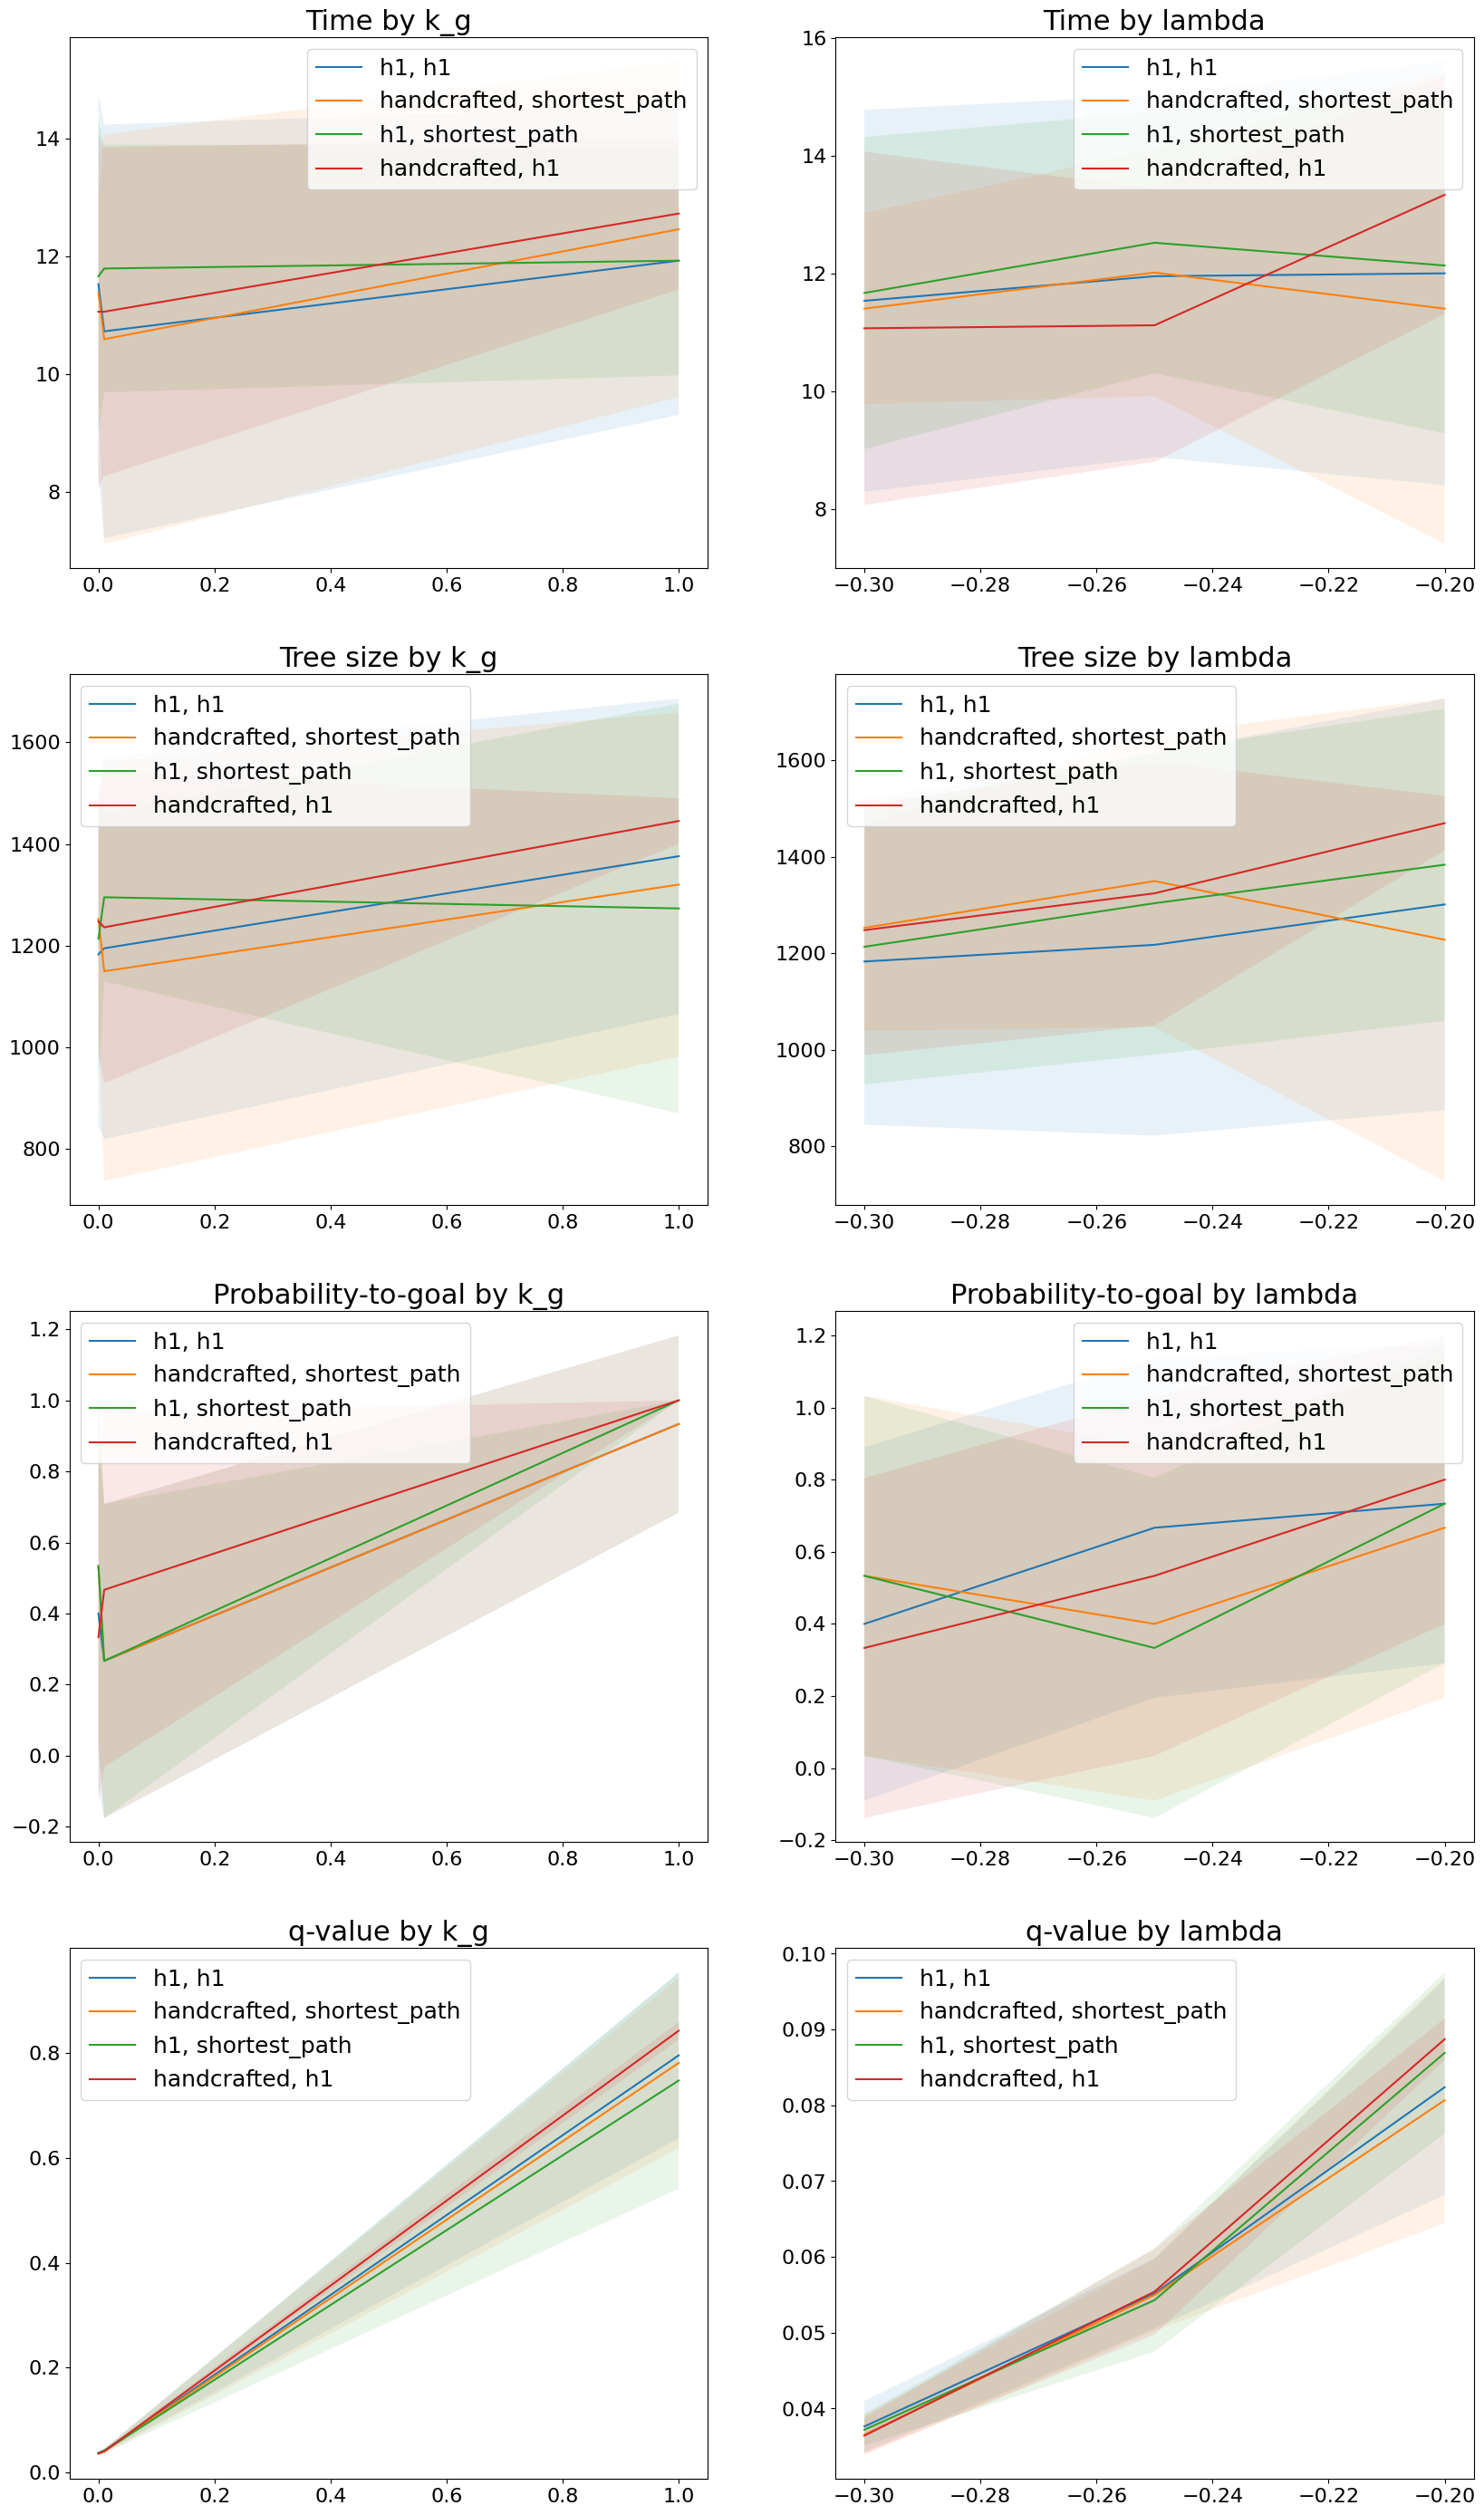

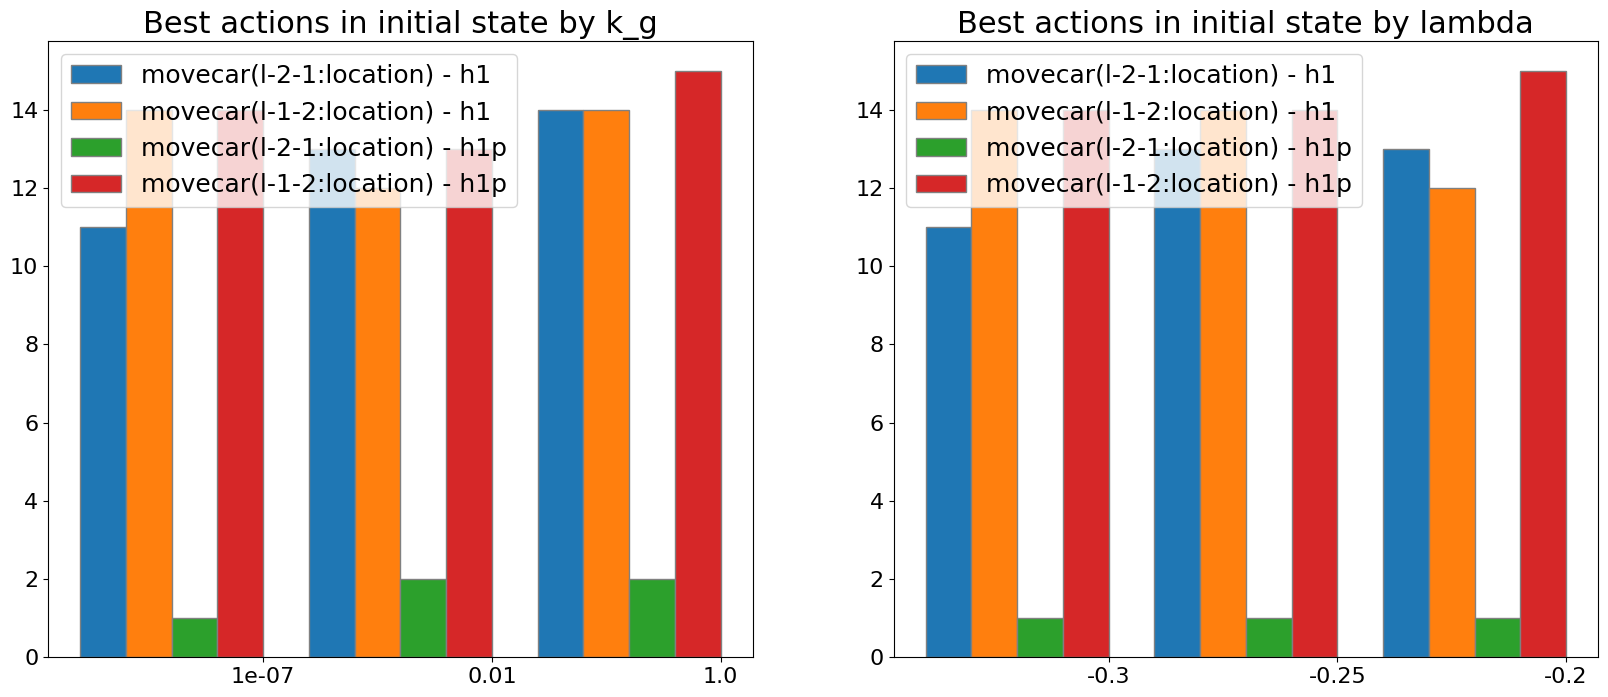

In [33]:
# COPIA DE RASCUNHO
# fix k_g and leave lambda as variable
y_vars = [
    ("cpu_times", "line"),
    ("tree_sizes", "line"),
    ("found_goal", "line"),
    ("values_s0", "line"),
    ("best_actions_s0", "bar")
]

source_runs = [
    h1_runs,
    h_runs,
    h1p_runs,
    h1u_runs,
]


plot_data_lamb = get_plot_data_by_fixed_var_from_sources(
    "args.lamb", -0.3,
    "args.k_g", y_vars,
    source_runs
)

sources_lambda_fixed_time, sources_lambda_fixed_size, sources_lambda_fixed_prob, sources_lambda_fixed_q, _sources_lamb_best_actions = get_plot_source_from_plot_data(plot_data_lamb)
sources_lamb_best_actions = parse_best_actions_plot_source(_sources_lamb_best_actions)


plot_data_kg = get_plot_data_by_fixed_var_from_sources(
    "args.k_g", 1e-7,
    "args.lamb", y_vars,
    source_runs
)
sources_kg_fixed_time, sources_kg_fixed_size, sources_kg_fixed_prob, sources_kg_fixed_q, _sources_kg_best_actions = get_plot_source_from_plot_data(plot_data_kg)
sources_kg_best_actions = parse_best_actions_plot_source(_sources_kg_best_actions)


labels = ["h1, h1", "handcrafted, shortest_path", "h1, shortest_path", "handcrafted, h1", "optimal"]

titles = [
    ["Time by k_g", "Time by lambda"],
    ["Tree size by k_g", "Tree size by lambda"],
    ["Probability-to-goal by k_g", "Probability-to-goal by lambda"],
    ["q-value by k_g", "q-value by lambda"]
]

# print("eita")
# pprint(sources_lambda_fixed_time)
# pprint(sources_kg_fixed_time)
# print("eita fim")

# print("eita2")
# pprint(sources_lambda_fixed_size)
# pprint(sources_kg_fixed_size)
# print("eita2 fim")
plot_multiple_from_plot_data_source_sets(
    [
        [sources_lambda_fixed_time, sources_kg_fixed_time],
        [sources_lambda_fixed_size, sources_kg_fixed_size],
        [sources_lambda_fixed_prob, sources_kg_fixed_prob],
        [sources_lambda_fixed_q, sources_kg_fixed_q]
    ],
    titles, labels, (4, 2), (20, 35), plot_type="line"
)

# Plot best actions at s0

labels = ['movecar(l-2-1:location) - h1', 'movecar(l-1-2:location) - h1', 'movecar(l-2-1:location) - h1p', 'movecar(l-1-2:location) - h1p']
titles = [["Best actions in initial state by k_g", "Best actions in initial state by lambda"]]

plot_multiple_from_plot_data_source_sets(
    [[sources_lamb_best_actions, sources_kg_best_actions]],
    titles, [labels, labels], (1, 2), (20, 8), bar_width=0.2, plot_type="bar"
)


In [19]:
y_vars = [
    ("cpu_times", "line"),
    ("tree_sizes", "line"),
    ("found_goal", "line"),
    ("values_s0", "line"),
    ("best_actions_s0", "bar")
]

source_runs = [
    h1_runs,
    h1p_runs,
    h1u_runs,
    h_runs
]

In [20]:
# fix lambda and leave kg as variable
[
    [
        h1_runs_by_kg_kgs,
        [
            (h1_runs_by_kg_time_mean, h1_runs_by_kg_time_std),
            (h1_runs_by_kg_size, h1_runs_by_kg_size_std),
            (h1_runs_by_kg_pg, h1_runs_by_kg_pg_std),
            (h1_runs_by_kg_q, h1_runs_by_kg_q_std),
            h1_runs_by_kg_best_actions
        ]
    ],
    [
        h1p_runs_by_kg_kgs,
        [
            (h1p_runs_by_kg_time_mean, h1p_runs_by_kg_time_std),
            (h1p_runs_by_kg_size, h1p_runs_by_kg_size_std),
            (h1p_runs_by_kg_pg, h1p_runs_by_kg_pg_std),
            (h1p_runs_by_kg_q, h1p_runs_by_kg_q_std),
            h1p_runs_by_kg_best_actions
        ]
    ],
    [
        h1u_runs_by_kg_kgs,
        [
            (h1u_runs_by_kg_time_mean, h1u_runs_by_kg_time_std),
            (h1u_runs_by_kg_size, h1u_runs_by_kg_size_std),
            (h1u_runs_by_kg_pg, h1u_runs_by_kg_pg_std),
            (h1u_runs_by_kg_q, h1u_runs_by_kg_q_std),
            h1u_runs_by_kg_best_actions
        ]
    ],
    [
        h_runs_by_kg_kgs,
        [
            (h_runs_by_kg_time_mean, h_runs_by_kg_time_std),
            (h_runs_by_kg_size, h_runs_by_kg_size_std),
            (h_runs_by_kg_pg, h_runs_by_kg_pg_std),
            (h_runs_by_kg_q, h_runs_by_kg_q_std),
            h_runs_by_kg_best_actions
        ]
    ]
] = get_plot_data_by_fixed_var_from_sources(
    "args.lamb", -0.3,
    "args.k_g", y_vars,
    source_runs
)


In [21]:
# fix k_g and leave lambda as variable

[
    [
        h1_runs_by_lamb_lambs,
        [
            (h1_runs_by_lamb_time_mean, h1_runs_by_lamb_time_std),
            (h1_runs_by_lamb_size, h1_runs_by_lamb_size_std),
            (h1_runs_by_lamb_pg, h1_runs_by_lamb_pg_std),
            (h1_runs_by_lamb_q, h1_runs_by_lamb_q_std),
            h1_runs_by_lamb_best_actions
        ]
    ],
    [
        h1p_runs_by_lamb_lambs,
        [
            (h1p_runs_by_lamb_time_mean, h1p_runs_by_lamb_time_std),
            (h1p_runs_by_lamb_size, h1p_runs_by_lamb_size_std),
            (h1p_runs_by_lamb_pg, h1p_runs_by_lamb_pg_std),
            (h1p_runs_by_lamb_q, h1p_runs_by_lamb_q_std),
            h1p_runs_by_lamb_best_actions
        ]
    ],
    [
        h1u_runs_by_lamb_lambs,
        [
            (h1u_runs_by_lamb_time_mean, h1u_runs_by_lamb_time_std),
            (h1u_runs_by_lamb_size, h1u_runs_by_lamb_size_std) ,
            (h1u_runs_by_lamb_pg, h1u_runs_by_lamb_pg_std) ,
            (h1u_runs_by_lamb_q, h1u_runs_by_lamb_q_std) ,
            h1u_runs_by_lamb_best_actions
        ]
    ],
    [
        h_runs_by_lamb_lambs,
        [
            (h_runs_by_lamb_time_mean, h_runs_by_lamb_time_std),
            (h_runs_by_lamb_size, h_runs_by_lamb_size_std),
            (h_runs_by_lamb_pg, h_runs_by_lamb_pg_std),
            (h_runs_by_lamb_q, h_runs_by_lamb_q_std),
            h_runs_by_lamb_best_actions
        ]
    ],
] = get_plot_data_by_fixed_var_from_sources(
    "args.k_g", 1e-7,
    "args.lamb", y_vars,
    source_runs
)


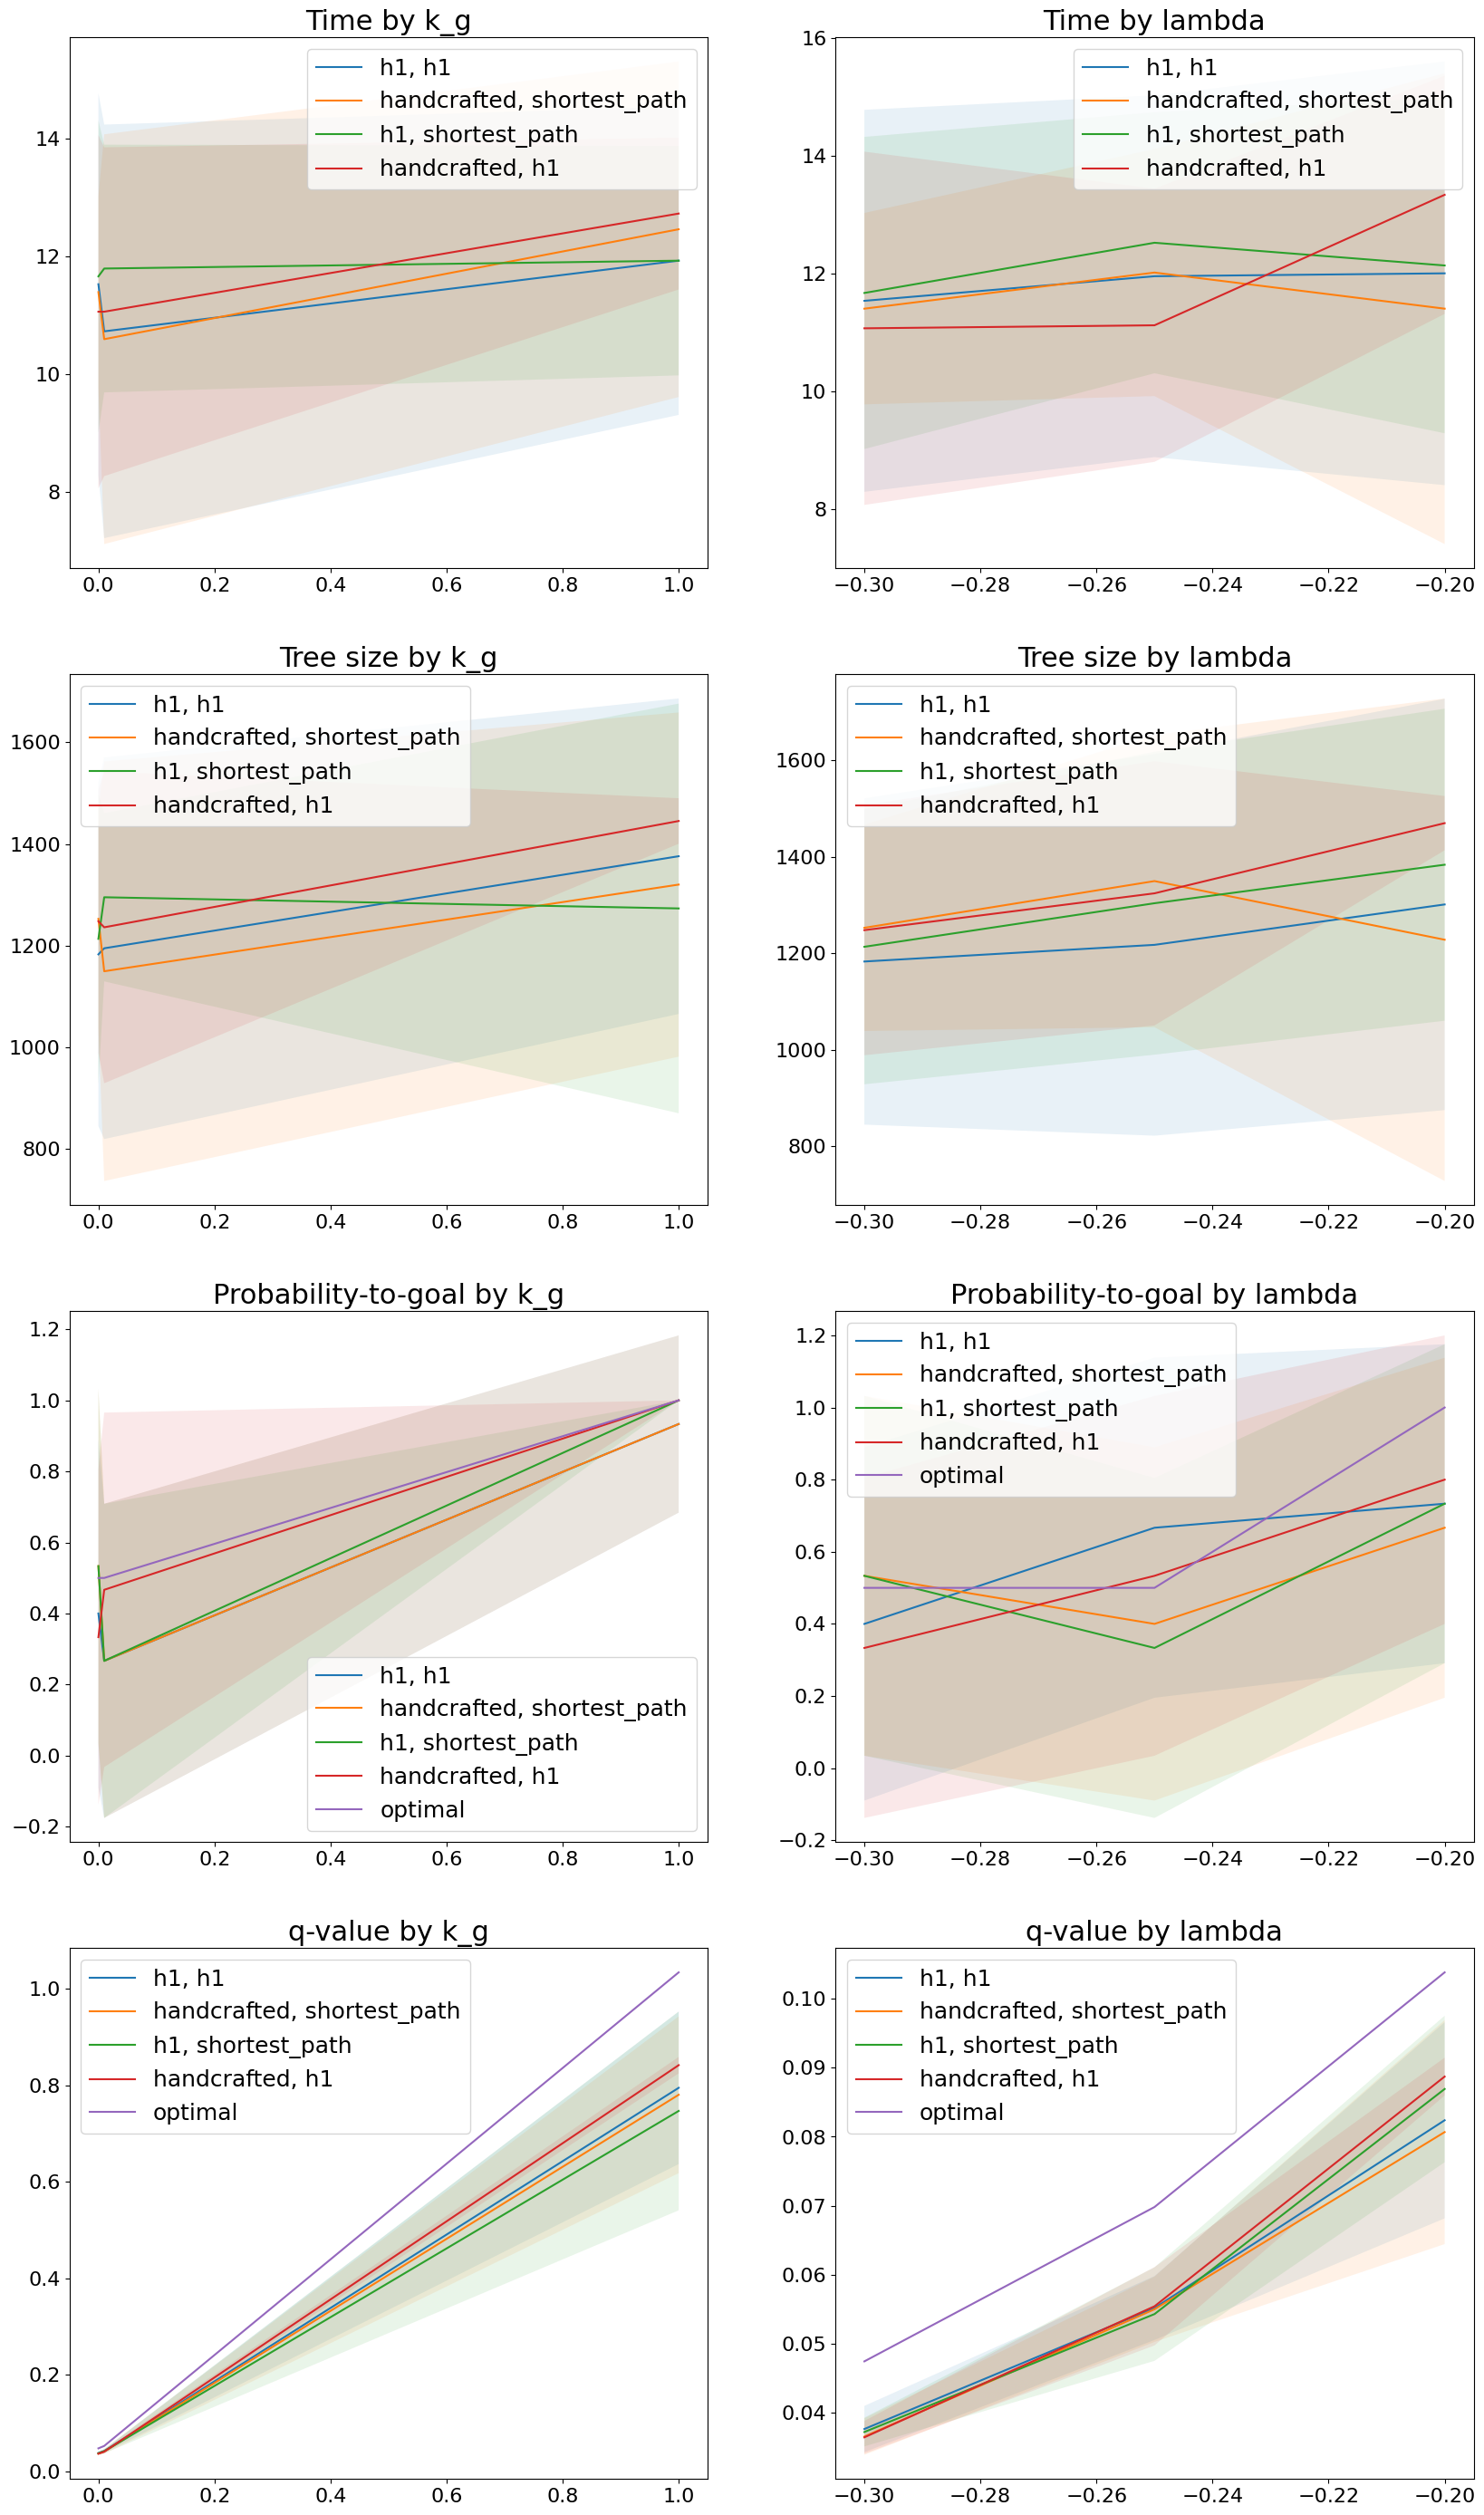

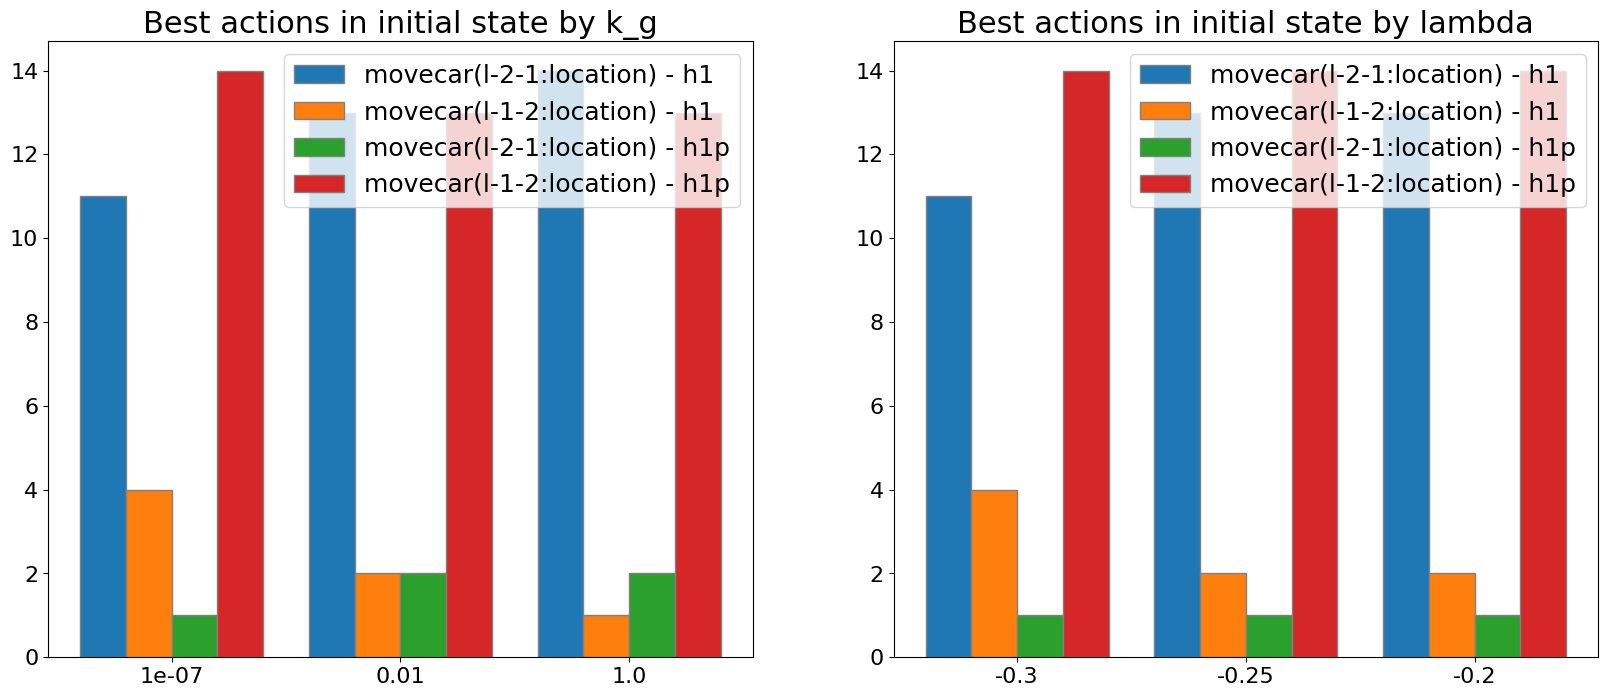

In [22]:
labels = ["h1, h1", "handcrafted, shortest_path", "h1, shortest_path", "handcrafted, h1", "optimal"]

# Time
sources_lambda_fixed_time = [
    (h1_runs_by_kg_kgs, h1_runs_by_kg_time_mean, h1_runs_by_kg_time_std),
    (h_runs_by_kg_kgs, h_runs_by_kg_time_mean, h_runs_by_kg_time_std),
    (h1p_runs_by_kg_kgs, h1p_runs_by_kg_time_mean, h1p_runs_by_kg_time_std),
    (h1u_runs_by_kg_kgs, h1u_runs_by_kg_time_mean, h1u_runs_by_kg_time_std),
]

sources_kg_fixed_time = [
    (h1_runs_by_lamb_lambs, h1_runs_by_lamb_time_mean, h1_runs_by_lamb_time_std),
    (h_runs_by_lamb_lambs, h_runs_by_lamb_time_mean, h_runs_by_lamb_time_std),
    (h1p_runs_by_lamb_lambs, h1p_runs_by_lamb_time_mean, h1p_runs_by_lamb_time_std),
    (h1u_runs_by_lamb_lambs, h1u_runs_by_lamb_time_mean, h1u_runs_by_lamb_time_std),
]

# Size
sources_lambda_fixed_size = [
    (h1_runs_by_kg_kgs, h1_runs_by_kg_size, h1_runs_by_kg_size_std),
    (h_runs_by_kg_kgs, h_runs_by_kg_size, h_runs_by_kg_size_std),
    (h1p_runs_by_kg_kgs, h1p_runs_by_kg_size, h1p_runs_by_kg_size_std),
    (h1u_runs_by_kg_kgs, h1u_runs_by_kg_size, h1u_runs_by_kg_size_std),
]

sources_kg_fixed_size = [
    (h1_runs_by_lamb_lambs, h1_runs_by_lamb_size, h1_runs_by_lamb_size_std),
    (h_runs_by_lamb_lambs, h_runs_by_lamb_size, h_runs_by_lamb_size_std),
    (h1p_runs_by_lamb_lambs, h1p_runs_by_lamb_size, h1p_runs_by_lamb_size_std),
    (h1u_runs_by_lamb_lambs, h1u_runs_by_lamb_size, h1u_runs_by_lamb_size_std),
]

# Probability-to-goal
lamb_opt_probs = np.fromiter(optimal_probs_by_kg_tireworld_1_03.values(), dtype=float)
sources_lambda_fixed_prob = [
    (h1_runs_by_kg_kgs, h1_runs_by_kg_pg, h1_runs_by_kg_pg_std),
    (h_runs_by_kg_kgs, h_runs_by_kg_pg, h_runs_by_kg_pg_std),
    (h1p_runs_by_kg_kgs, h1p_runs_by_kg_pg, h1p_runs_by_kg_pg_std),
    (h1u_runs_by_kg_kgs, h1u_runs_by_kg_pg, h1u_runs_by_kg_pg_std),
    (h1u_runs_by_kg_kgs, lamb_opt_probs)
]

kg_opt_probs = np.array([prob for k_g, prob in optimal_probs_by_lamb_tireworld_1_1e7.items()])
sources_kg_fixed_prob = [
    (h1_runs_by_lamb_lambs, h1_runs_by_lamb_pg, h1_runs_by_lamb_pg_std),
    (h_runs_by_lamb_lambs, h_runs_by_lamb_pg, h_runs_by_lamb_pg_std),
    (h1p_runs_by_lamb_lambs, h1p_runs_by_lamb_pg, h1p_runs_by_lamb_pg_std),
    (h1u_runs_by_lamb_lambs, h1u_runs_by_lamb_pg, h1u_runs_by_lamb_pg_std),
    (h1u_runs_by_lamb_lambs, kg_opt_probs)
]


# Q-values
lamb_opt_qs = np.fromiter(optimal_qs_by_kg_tireworld_1_03.values(), dtype=float)
sources_lambda_fixed_q = [
    (h1_runs_by_kg_kgs, h1_runs_by_kg_q, h1_runs_by_kg_q_std),
    (h_runs_by_kg_kgs, h_runs_by_kg_q, h_runs_by_kg_q_std),
    (h1p_runs_by_kg_kgs, h1p_runs_by_kg_q, h1p_runs_by_kg_q_std),
    (h1u_runs_by_kg_kgs, h1u_runs_by_kg_q, h1u_runs_by_kg_q_std),
    (h1u_runs_by_kg_kgs, lamb_opt_qs)
]

kg_opt_qs = np.fromiter(optimal_qs_by_lamb_tireworld_1_1e7.values(), dtype=float)
sources_kg_fixed_q = [
    (h1_runs_by_lamb_lambs, h1_runs_by_lamb_q, h1_runs_by_lamb_q_std),
    (h_runs_by_lamb_lambs, h_runs_by_lamb_q, h_runs_by_lamb_q_std),
    (h1p_runs_by_lamb_lambs, h1p_runs_by_lamb_q, h1p_runs_by_lamb_q_std),
    (h1u_runs_by_lamb_lambs, h1u_runs_by_lamb_q, h1u_runs_by_lamb_q_std),
    (h1u_runs_by_lamb_lambs, kg_opt_qs)
]

titles = [
    ["Time by k_g", "Time by lambda"],
    ["Tree size by k_g", "Tree size by lambda"],
    ["Probability-to-goal by k_g", "Probability-to-goal by lambda"],
    ["q-value by k_g", "q-value by lambda"]
]

plot_multiple_from_plot_data_source_sets(
    [
        [sources_lambda_fixed_time, sources_kg_fixed_time],
        [sources_lambda_fixed_size, sources_kg_fixed_size],
        [sources_lambda_fixed_prob, sources_kg_fixed_prob],
        [sources_lambda_fixed_q, sources_kg_fixed_q]
    ],
    titles, labels, (4, 2), (20, 35), plot_type="line"
)

# Plot best actions at s0
# pprint(sources_lambda_fixed)
labels = ['movecar(l-2-1:location) - h1', 'movecar(l-1-2:location) - h1', 'movecar(l-2-1:location) - h1p', 'movecar(l-1-2:location) - h1p']
titles = [["Best actions in initial state by k_g", "Best actions in initial state by lambda"]]

sources_lamb_best_actions = [
    (h1_runs_by_kg_kgs, h1_runs_by_kg_best_actions + h1p_runs_by_kg_best_actions),
]

sources_kg_best_actions = [
    (h1_runs_by_lamb_lambs, h1_runs_by_lamb_best_actions + h1p_runs_by_lamb_best_actions),
]

# pprint(sources_kg_best_actions)
plot_multiple_from_plot_data_source_sets(
    [[sources_lamb_best_actions, sources_kg_best_actions]],
    titles, [labels, labels], (1, 2), (20, 8), bar_width=0.2, plot_type="bar"
)


In [23]:
# DRAFT!

# source_h1 = filter_runs_by_prop("args.lamb", -0.3, h1_runs)
# source_h1p = filter_runs_by_prop("args.lamb", -0.3, h1p_runs)


# x_var_path = "args.k_g"

# xs_h1 , yss_h1 =get_plot_data(x_var_path, [("best_actions_s0", "bar")], source_h1)
# xs_h1p , yss_h1p =get_plot_data(x_var_path, [("best_actions_s0", "bar")], source_h1p)
# print("oi", xs_h1, yss_h1[0] + yss_h1p[0])

# labels=['movecar(l-2-1:location) - h1', 'movecar(l-1-2:location) - h1', 'movecar(l-2-1:location) - h1p', 'movecar(l-1-2:location) - h1p']
# _, ax = plt.subplots(figsize=(10,5))
# plot_bars(xs_h1, yss_h1[0] + yss_h1p[0], labels, ax=ax, bar_width=0.15)
# plot_bars(xs_h1, yss_h1p[0], labels=sorted(['movecar(l-2-1:location) - h1p', 'movecar(l-1-2:location) - h1p']), ax=ax)


# Evaluate normalizing

In [24]:
# Evaluate normalizing

base_params = [
    ("args.problem_index", 1), ("args.n_rollouts", 1000),
    ("args.h_init_count", 20), ("args.horizon", 100),
    ("args.h_u", "shortest_path"), ("args.h_p", "handcrafted")
]

norm_runs = filter_runs_by_props(info_runs, ("args.norm_exploration_constant", True), *base_params)
no_norm_runs = filter_runs_by_props(info_runs, ("args.norm_exploration_constant", False), *base_params)

# check for intersection - shouldn't have any
# ----------------------------------------------------------------
check_for_intersections([
    norm_runs,
    no_norm_runs
])
# ----------------------------------------------------------------

print(len(norm_runs), len(no_norm_runs))

9 9


In [25]:
# fix lambda and leave kg as variable

y_vars = [
    ("cpu_times", "line"),
    ("tree_sizes", "line"),
    ("found_goal", "line"),
    ("values_s0", "line"),
    ("best_actions_s0", "bar")
]
source_runs = [
    norm_runs,
    no_norm_runs
]

plot_datas_by_kg = get_plot_data_by_fixed_var_from_sources(
    "args.lamb", -0.3,
    "args.k_g", y_vars,
    source_runs
)

(
    norm_runs_by_kg_kgs,
    (norm_runs_by_kg_time_mean, norm_runs_by_kg_time_std),
    (norm_runs_by_kg_size, norm_runs_by_kg_size_std),
    (norm_runs_by_kg_pg, norm_runs_by_kg_pg_std),
    (norm_runs_by_kg_qs, norm_runs_by_kg_qs_std),
    norm_runs_by_kg_best_actions
)  = plot_datas_by_kg[0][0], plot_datas_by_kg[0][1][0], plot_datas_by_kg[0][1][1], plot_datas_by_kg[0][1][2], plot_datas_by_kg[0][1][3], plot_datas_by_kg[0][1][4]

(
    no_norm_runs_by_kg_kgs,
    (no_norm_runs_by_kg_time_mean, no_norm_runs_by_kg_time_std),
    (no_norm_runs_by_kg_size, no_norm_runs_by_kg_size_std),
    (no_norm_runs_by_kg_pg, no_norm_runs_by_kg_pg_std),
    (no_norm_runs_by_kg_qs, no_norm_runs_by_kg_qs_std),
    no_norm_runs_by_kg_best_actions
) = plot_datas_by_kg[1][0], plot_datas_by_kg[1][1][0], plot_datas_by_kg[1][1][1], plot_datas_by_kg[0][1][2], plot_datas_by_kg[0][1][3], plot_datas_by_kg[0][1][4]

# fix k_g and leave lambda as variable
plot_datas_by_lamb = get_plot_data_by_fixed_var_from_sources(
    "args.k_g", 1e-7,
    "args.lamb", y_vars,
    source_runs
)

(
    norm_runs_by_lamb_lambs,
    (norm_runs_by_lamb_time_mean, norm_runs_by_lamb_time_std),
    (norm_runs_by_lamb_size, norm_runs_by_lamb_size_std),
    (norm_runs_by_lamb_pg, norm_runs_by_lamb_pg_std),
    (norm_runs_by_lamb_qs, norm_runs_by_lamb_qs_std),
    norm_runs_by_lamb_best_actions
) = plot_datas_by_lamb[0][0], plot_datas_by_lamb[0][1][0], plot_datas_by_lamb[0][1][1], plot_datas_by_lamb[0][1][2], plot_datas_by_lamb[0][1][3], plot_datas_by_lamb[0][1][4]

(
    no_norm_runs_by_lamb_lambs,
    (no_norm_runs_by_lamb_time_mean, no_norm_runs_by_lamb_time_std),
    (no_norm_runs_by_lamb_size, no_norm_runs_by_lamb_size_std),
    (no_norm_runs_by_lamb_pg, no_norm_runs_by_lamb_pg_std),
    (no_norm_runs_by_lamb_qs, no_norm_runs_by_lamb_qs_std),
    no_norm_runs_by_lamb_best_actions
) = plot_datas_by_lamb[1][0], plot_datas_by_lamb[1][1][0], plot_datas_by_lamb[1][1][1], plot_datas_by_lamb[0][1][2], plot_datas_by_lamb[0][1][3], plot_datas_by_lamb[0][1][4]


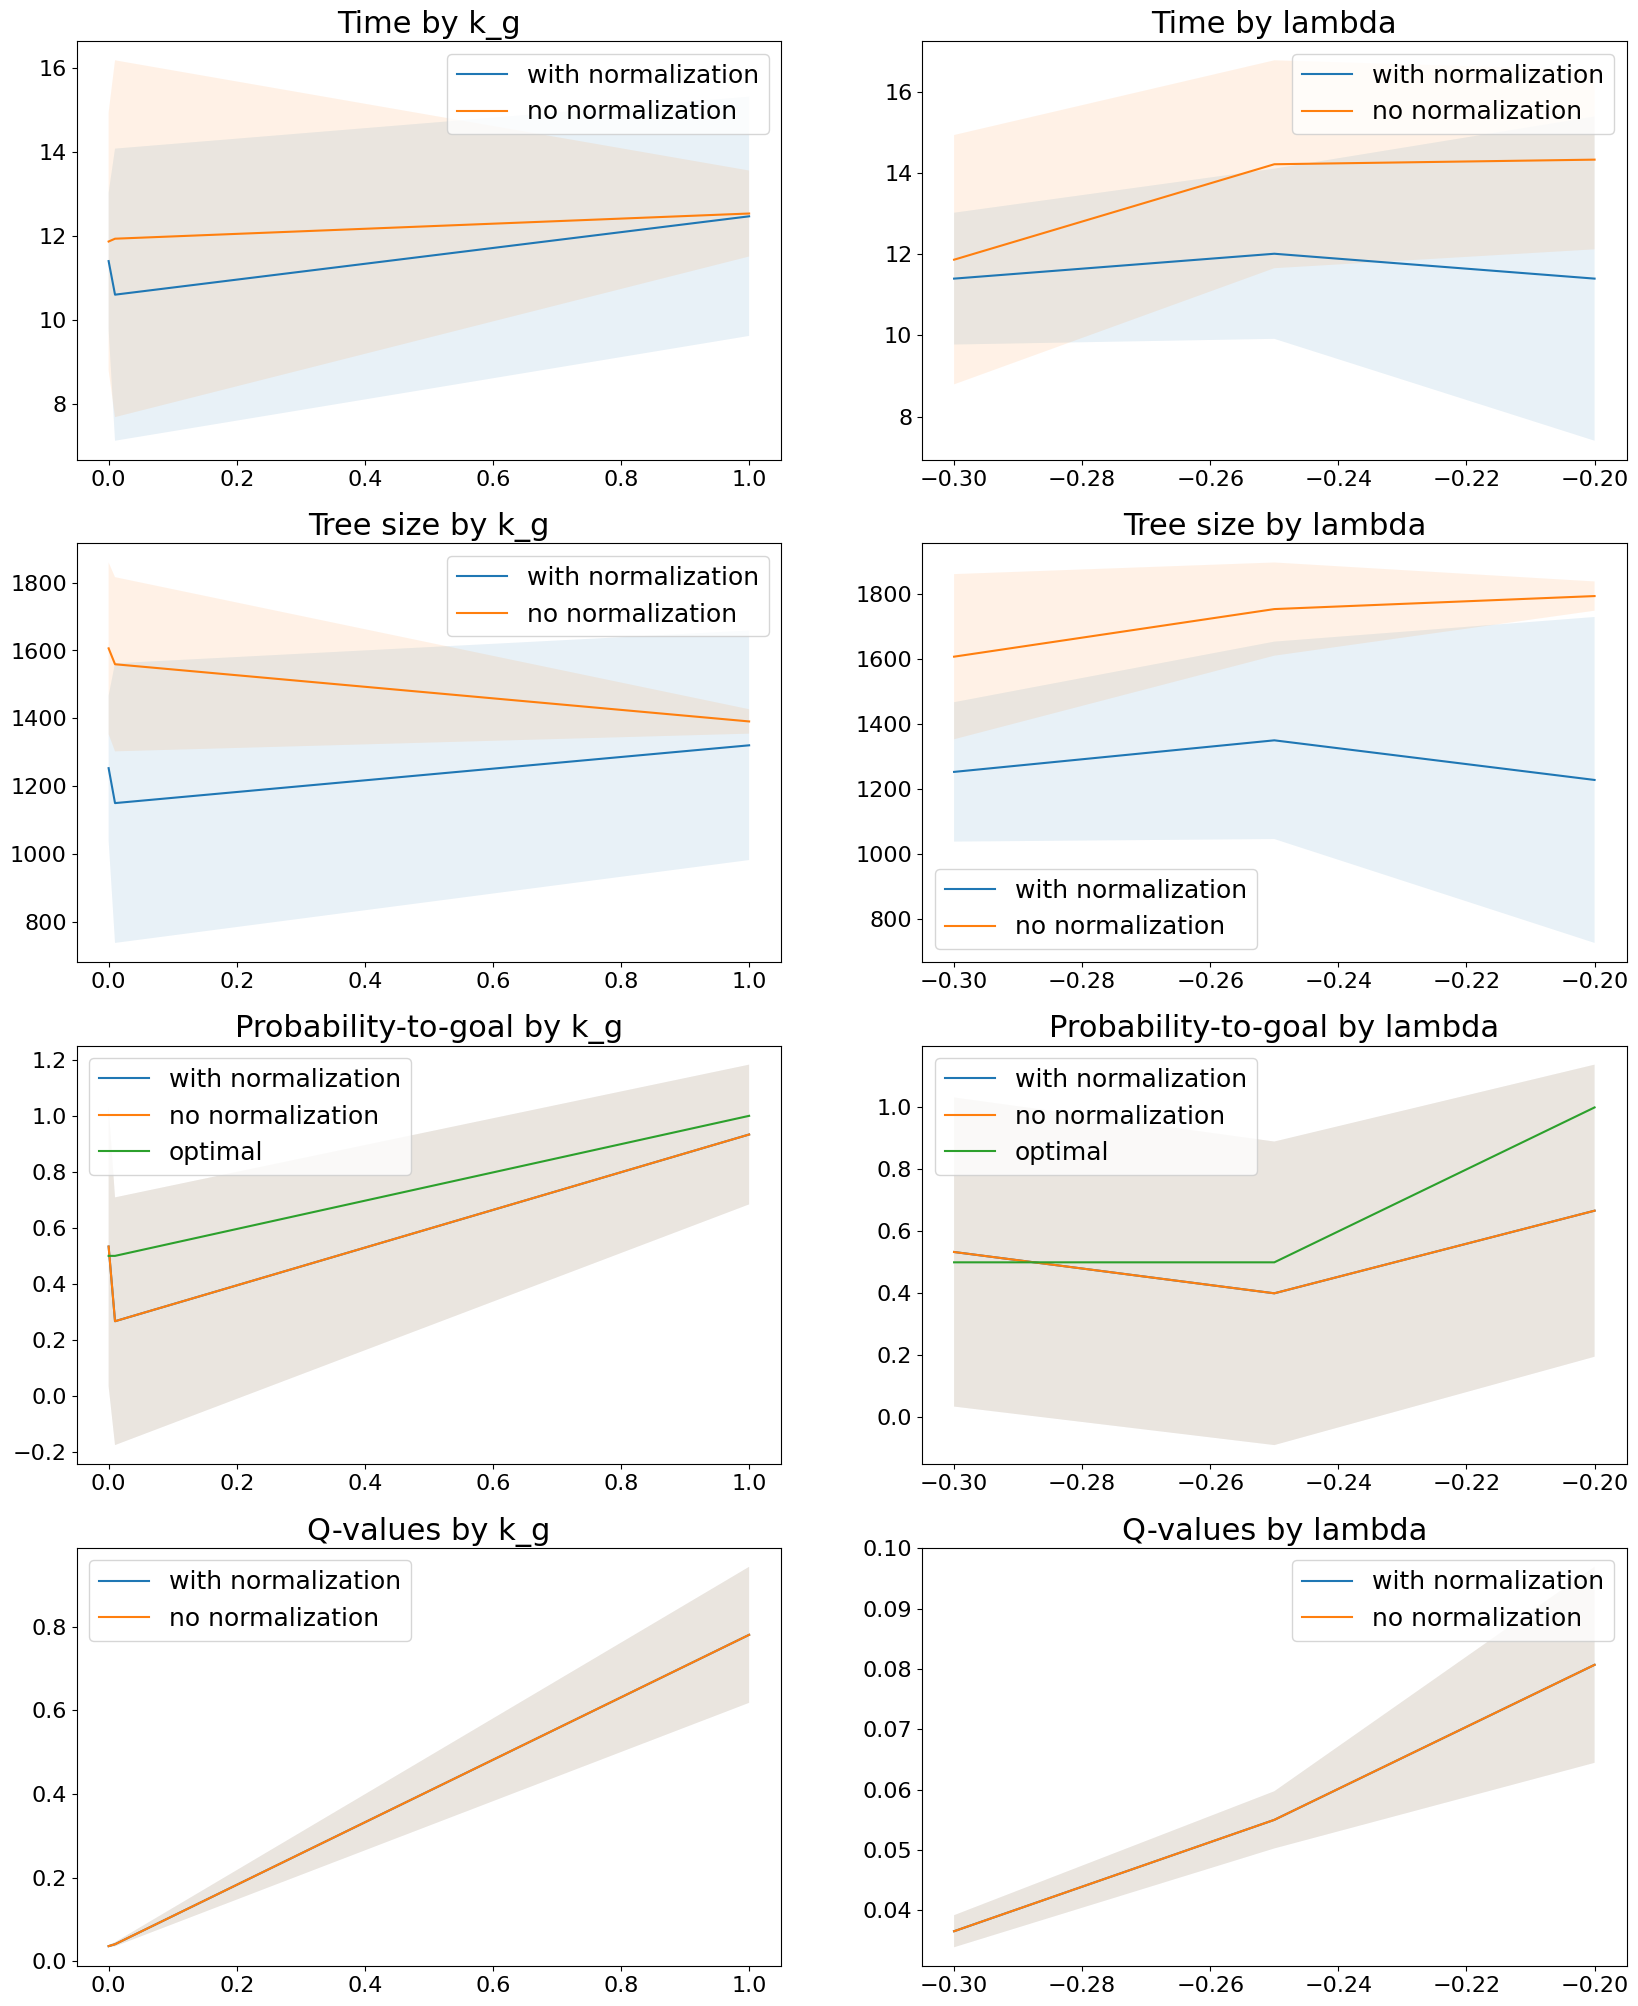

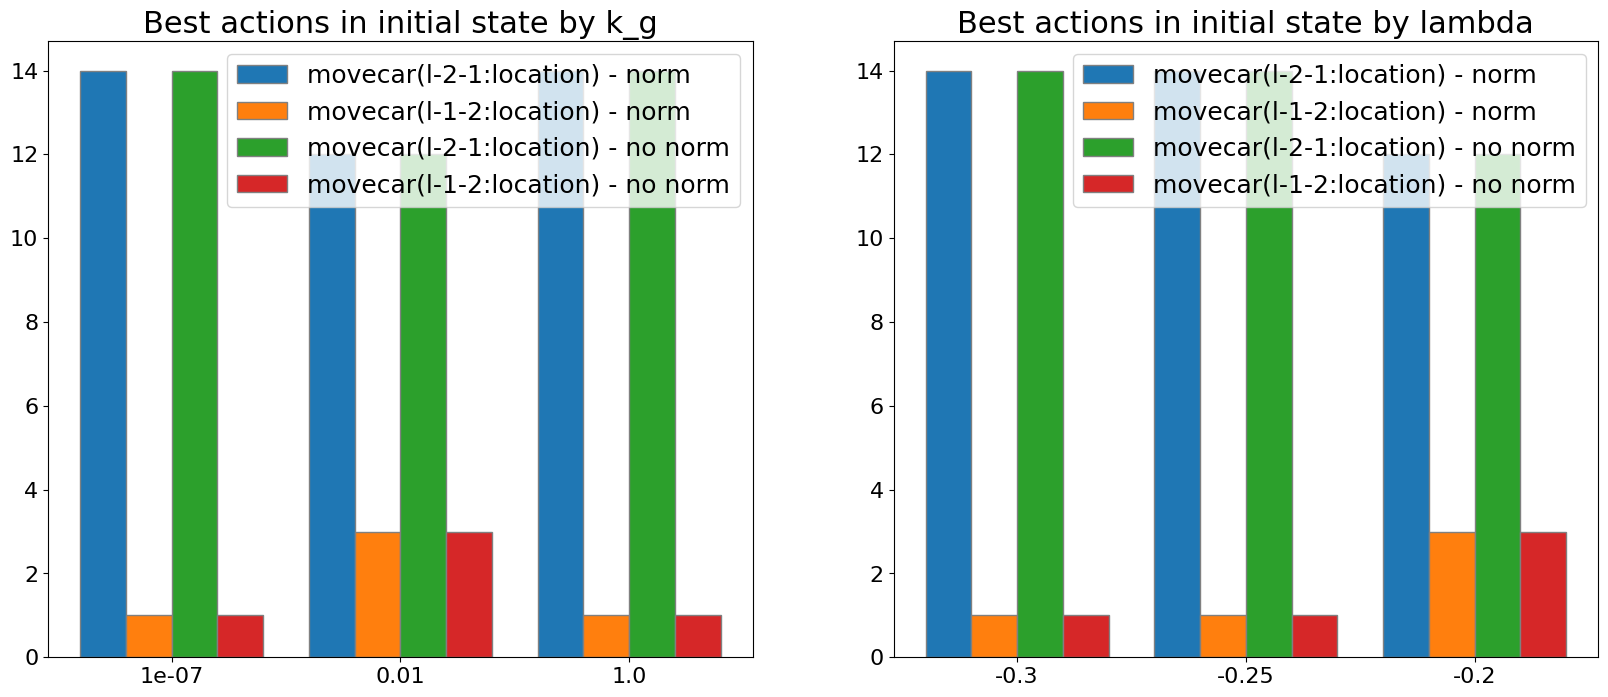

In [26]:
labels = ["with normalization", "no normalization", "optimal"]

# time
sources_lambda_fixed_time = [
   (norm_runs_by_kg_kgs, norm_runs_by_kg_time_mean, norm_runs_by_kg_time_std),
    (no_norm_runs_by_kg_kgs, no_norm_runs_by_kg_time_mean, no_norm_runs_by_kg_time_std),
]

sources_kg_fixed_time = [
    (norm_runs_by_lamb_lambs, norm_runs_by_lamb_time_mean, norm_runs_by_lamb_time_std),
    (no_norm_runs_by_lamb_lambs, no_norm_runs_by_lamb_time_mean, no_norm_runs_by_lamb_time_std),
]

# tree size

sources_lambda_fixed_size = [
    (norm_runs_by_kg_kgs, norm_runs_by_kg_size, norm_runs_by_kg_size_std),
    (no_norm_runs_by_kg_kgs, no_norm_runs_by_kg_size, no_norm_runs_by_kg_size_std),
]

sources_kg_fixed_size = [
    (norm_runs_by_lamb_lambs, norm_runs_by_lamb_size, norm_runs_by_lamb_size_std),
    (no_norm_runs_by_lamb_lambs, no_norm_runs_by_lamb_size, no_norm_runs_by_lamb_size_std),
]

# probability-to-goal

sources_lambda_fixed_prob = [
    (norm_runs_by_kg_kgs, norm_runs_by_kg_pg, norm_runs_by_kg_pg_std),
    (no_norm_runs_by_kg_kgs, no_norm_runs_by_kg_pg, no_norm_runs_by_kg_pg_std),
    (no_norm_runs_by_kg_kgs, lamb_opt_probs)
]

sources_kg_fixed_prob = [
    (norm_runs_by_lamb_lambs, norm_runs_by_lamb_pg, norm_runs_by_lamb_pg_std),
    (no_norm_runs_by_lamb_lambs, no_norm_runs_by_lamb_pg, no_norm_runs_by_lamb_pg_std),
    (no_norm_runs_by_lamb_lambs, kg_opt_probs)
]

# TODO -> investigar porque os qs tao iguais aqui pra norm e nao norm
# qs
sources_lambda_fixed_qs = [
    (norm_runs_by_kg_kgs, norm_runs_by_kg_qs, norm_runs_by_kg_qs_std),
    (no_norm_runs_by_kg_kgs, no_norm_runs_by_kg_qs, no_norm_runs_by_kg_qs_std),
#     (no_norm_runs_by_kg_kgs, lamb_opt_qs)
]

sources_kg_fixed_qs = [
    (norm_runs_by_lamb_lambs, norm_runs_by_lamb_qs, norm_runs_by_lamb_qs_std),
    (no_norm_runs_by_lamb_lambs, no_norm_runs_by_lamb_qs, no_norm_runs_by_lamb_qs_std),
#     (no_norm_runs_by_lamb_kgs, kg_opt_qs)
]
titles = [
    ["Time by k_g", "Time by lambda"],
    ["Tree size by k_g", "Tree size by lambda"],
    ["Probability-to-goal by k_g", "Probability-to-goal by lambda"],
    ["Q-values by k_g", "Q-values by lambda"],
]


plot_multiple_from_plot_data_source_sets([
    [sources_lambda_fixed_time, sources_kg_fixed_time],
    [sources_lambda_fixed_size, sources_kg_fixed_size],
    [sources_lambda_fixed_prob, sources_kg_fixed_prob],
    [sources_lambda_fixed_qs, sources_kg_fixed_qs],
], titles, labels, (4, 2), (20, 25))

labels = ['movecar(l-2-1:location) - norm', 'movecar(l-1-2:location) - norm', 'movecar(l-2-1:location) - no norm', 'movecar(l-1-2:location) - no norm']
titles = [["Best actions in initial state by k_g", "Best actions in initial state by lambda"]]

sources_kg_best_actions = [
    (norm_runs_by_kg_kgs, norm_runs_by_kg_best_actions + no_norm_runs_by_kg_best_actions),
]

sources_lamb_best_actions = [
    (norm_runs_by_lamb_lambs, norm_runs_by_lamb_best_actions + no_norm_runs_by_lamb_best_actions),
]

# pprint(sources_kg_best_actions)
plot_multiple_from_plot_data_source_sets(
    [[sources_kg_best_actions, sources_lamb_best_actions]],
    titles, [labels, labels], (1, 2), (20, 8), bar_width=0.2, plot_type="bar"
)

# Evaluate number of rollouts

In [27]:
# Evaluate normalizing

base_params = [
    ("args.problem_index", 1), ("args.norm_exploration_constant", True),
    ("args.h_init_count", 20), ("args.horizon", 100),
    ("args.h_u", "shortest_path"), ("args.h_p", "handcrafted")
]

n_rollouts_50_runs   = filter_runs_by_props(info_runs, ("args.n_rollouts", 50), *base_params)
n_rollouts_100_runs  = filter_runs_by_props(info_runs, ("args.n_rollouts", 100), *base_params)
n_rollouts_1000_runs = filter_runs_by_props(info_runs, ("args.n_rollouts", 1000), *base_params)

# check for intersection - shouldn't have any
# ----------------------------------------------------------------
check_for_intersections([
    n_rollouts_50_runs,
    n_rollouts_100_runs,
    n_rollouts_1000_runs
])
# ----------------------------------------------------------------

print(len(n_rollouts_50_runs), len(n_rollouts_100_runs), len(n_rollouts_1000_runs))

9 9 9


In [28]:
# fix lambda and leave kg as variable

y_vars = [
    ("cpu_times", "line"),
    ("tree_sizes", "line"),
    ("found_goal", "line"),
    ("values_s0", "line"),
    ("best_actions_s0", "bar")
]

source_runs = [
    n_rollouts_50_runs,
    n_rollouts_100_runs,
    n_rollouts_1000_runs
]

plot_datas_by_kg = get_plot_data_by_fixed_var_from_sources(
    "args.lamb", -0.3,
    "args.k_g", y_vars,
    source_runs
)

(
    n_rollouts_50_runs_by_kg_kgs,
    (n_rollouts_50_runs_by_kg_time_mean, n_rollouts_50_runs_by_kg_time_std),
    (n_rollouts_50_runs_by_kg_size, n_rollouts_50_runs_by_kg_size_std),
    (n_rollouts_50_runs_by_kg_pg, n_rollouts_50_runs_by_kg_pg_std),
    (n_rollouts_50_runs_by_kg_qs, n_rollouts_50_runs_by_kg_qs_std),
    n_rollouts_50_runs_best_actions_s0_by_kg
)  = plot_datas_by_kg[0][0], plot_datas_by_kg[0][1][0], plot_datas_by_kg[0][1][1], plot_datas_by_kg[0][1][2], plot_datas_by_kg[0][1][3], plot_datas_by_kg[0][1][4]

(
    n_rollouts_100_runs_by_kg_kgs,
    (n_rollouts_100_runs_by_kg_time_mean, n_rollouts_100_runs_by_kg_time_std),
    (n_rollouts_100_runs_by_kg_size, n_rollouts_100_runs_by_kg_size_std),
    (n_rollouts_100_runs_by_kg_pg, n_rollouts_100_runs_by_kg_pg_std),
    (n_rollouts_100_runs_by_kg_qs, n_rollouts_100_runs_by_kg_qs_std),
    n_rollouts_100_runs_best_actions_s0_by_kg
) = plot_datas_by_kg[1][0], plot_datas_by_kg[1][1][0], plot_datas_by_kg[1][1][1], plot_datas_by_kg[1][1][2], plot_datas_by_kg[1][1][3], plot_datas_by_kg[1][1][4]

(
    n_rollouts_1000_runs_by_kg_kgs,
    (n_rollouts_1000_runs_by_kg_time_mean, n_rollouts_1000_runs_by_kg_time_std),
    (n_rollouts_1000_runs_by_kg_size, n_rollouts_1000_runs_by_kg_size_std),
    (n_rollouts_1000_runs_by_kg_pg, n_rollouts_1000_runs_by_kg_pg_std),
    (n_rollouts_1000_runs_by_kg_qs, n_rollouts_1000_runs_by_kg_qs_std),
    n_rollouts_1000_runs_best_actions_s0_by_kg
) = plot_datas_by_kg[2][0], plot_datas_by_kg[2][1][0], plot_datas_by_kg[2][1][1], plot_datas_by_kg[2][1][2], plot_datas_by_kg[2][1][3], plot_datas_by_kg[2][1][4]

# fix k_g and leave lambda as variable
plot_datas_by_lamb = get_plot_data_by_fixed_var_from_sources(
    "args.k_g", 1e-7,
    "args.lamb", y_vars,
    source_runs
)

(
    n_rollouts_50_runs_by_lamb_kgs,
    (n_rollouts_50_runs_by_lamb_time_mean, n_rollouts_50_runs_by_lamb_time_std),
    (n_rollouts_50_runs_by_lamb_size, n_rollouts_50_runs_by_lamb_size_std),
    (n_rollouts_50_runs_by_lamb_pg, n_rollouts_50_runs_by_lamb_pg_std),
    (n_rollouts_50_runs_by_lamb_qs, n_rollouts_50_runs_by_lamb_qs_std),
    n_rollouts_50_runs_best_actions_s0_by_lamb
) = plot_datas_by_lamb[0][0], plot_datas_by_lamb[0][1][0], plot_datas_by_lamb[0][1][1], plot_datas_by_lamb[0][1][2], plot_datas_by_lamb[0][1][3], plot_datas_by_lamb[0][1][4]

(
    n_rollouts_100_runs_by_lamb_kgs,
    (n_rollouts_100_runs_by_lamb_time_mean, n_rollouts_100_runs_by_lamb_time_std),
    (n_rollouts_100_runs_by_lamb_size, n_rollouts_100_runs_by_lamb_size_std),
    (n_rollouts_100_runs_by_lamb_pg, n_rollouts_100_runs_by_lamb_pg_std),
    (n_rollouts_100_runs_by_lamb_qs, n_rollouts_100_runs_by_lamb_qs_std),
    n_rollouts_100_runs_best_actions_s0_by_lamb
) = plot_datas_by_lamb[1][0], plot_datas_by_lamb[1][1][0], plot_datas_by_lamb[1][1][1], plot_datas_by_lamb[1][1][2], plot_datas_by_lamb[1][1][3], plot_datas_by_lamb[1][1][4]

(
    n_rollouts_1000_runs_by_lamb_kgs,
    (n_rollouts_1000_runs_by_lamb_time_mean, n_rollouts_1000_runs_by_lamb_time_std),
    (n_rollouts_1000_runs_by_lamb_size, n_rollouts_1000_runs_by_lamb_size_std),
    (n_rollouts_1000_runs_by_lamb_pg, n_rollouts_1000_runs_by_lamb_pg_std),
    (n_rollouts_1000_runs_by_lamb_qs, n_rollouts_1000_runs_by_lamb_qs_std),
    n_rollouts_1000_runs_best_actions_s0_by_lamb
) = plot_datas_by_lamb[2][0], plot_datas_by_lamb[2][1][0], plot_datas_by_lamb[2][1][1], plot_datas_by_lamb[2][1][2], plot_datas_by_lamb[2][1][3], plot_datas_by_lamb[2][1][4]


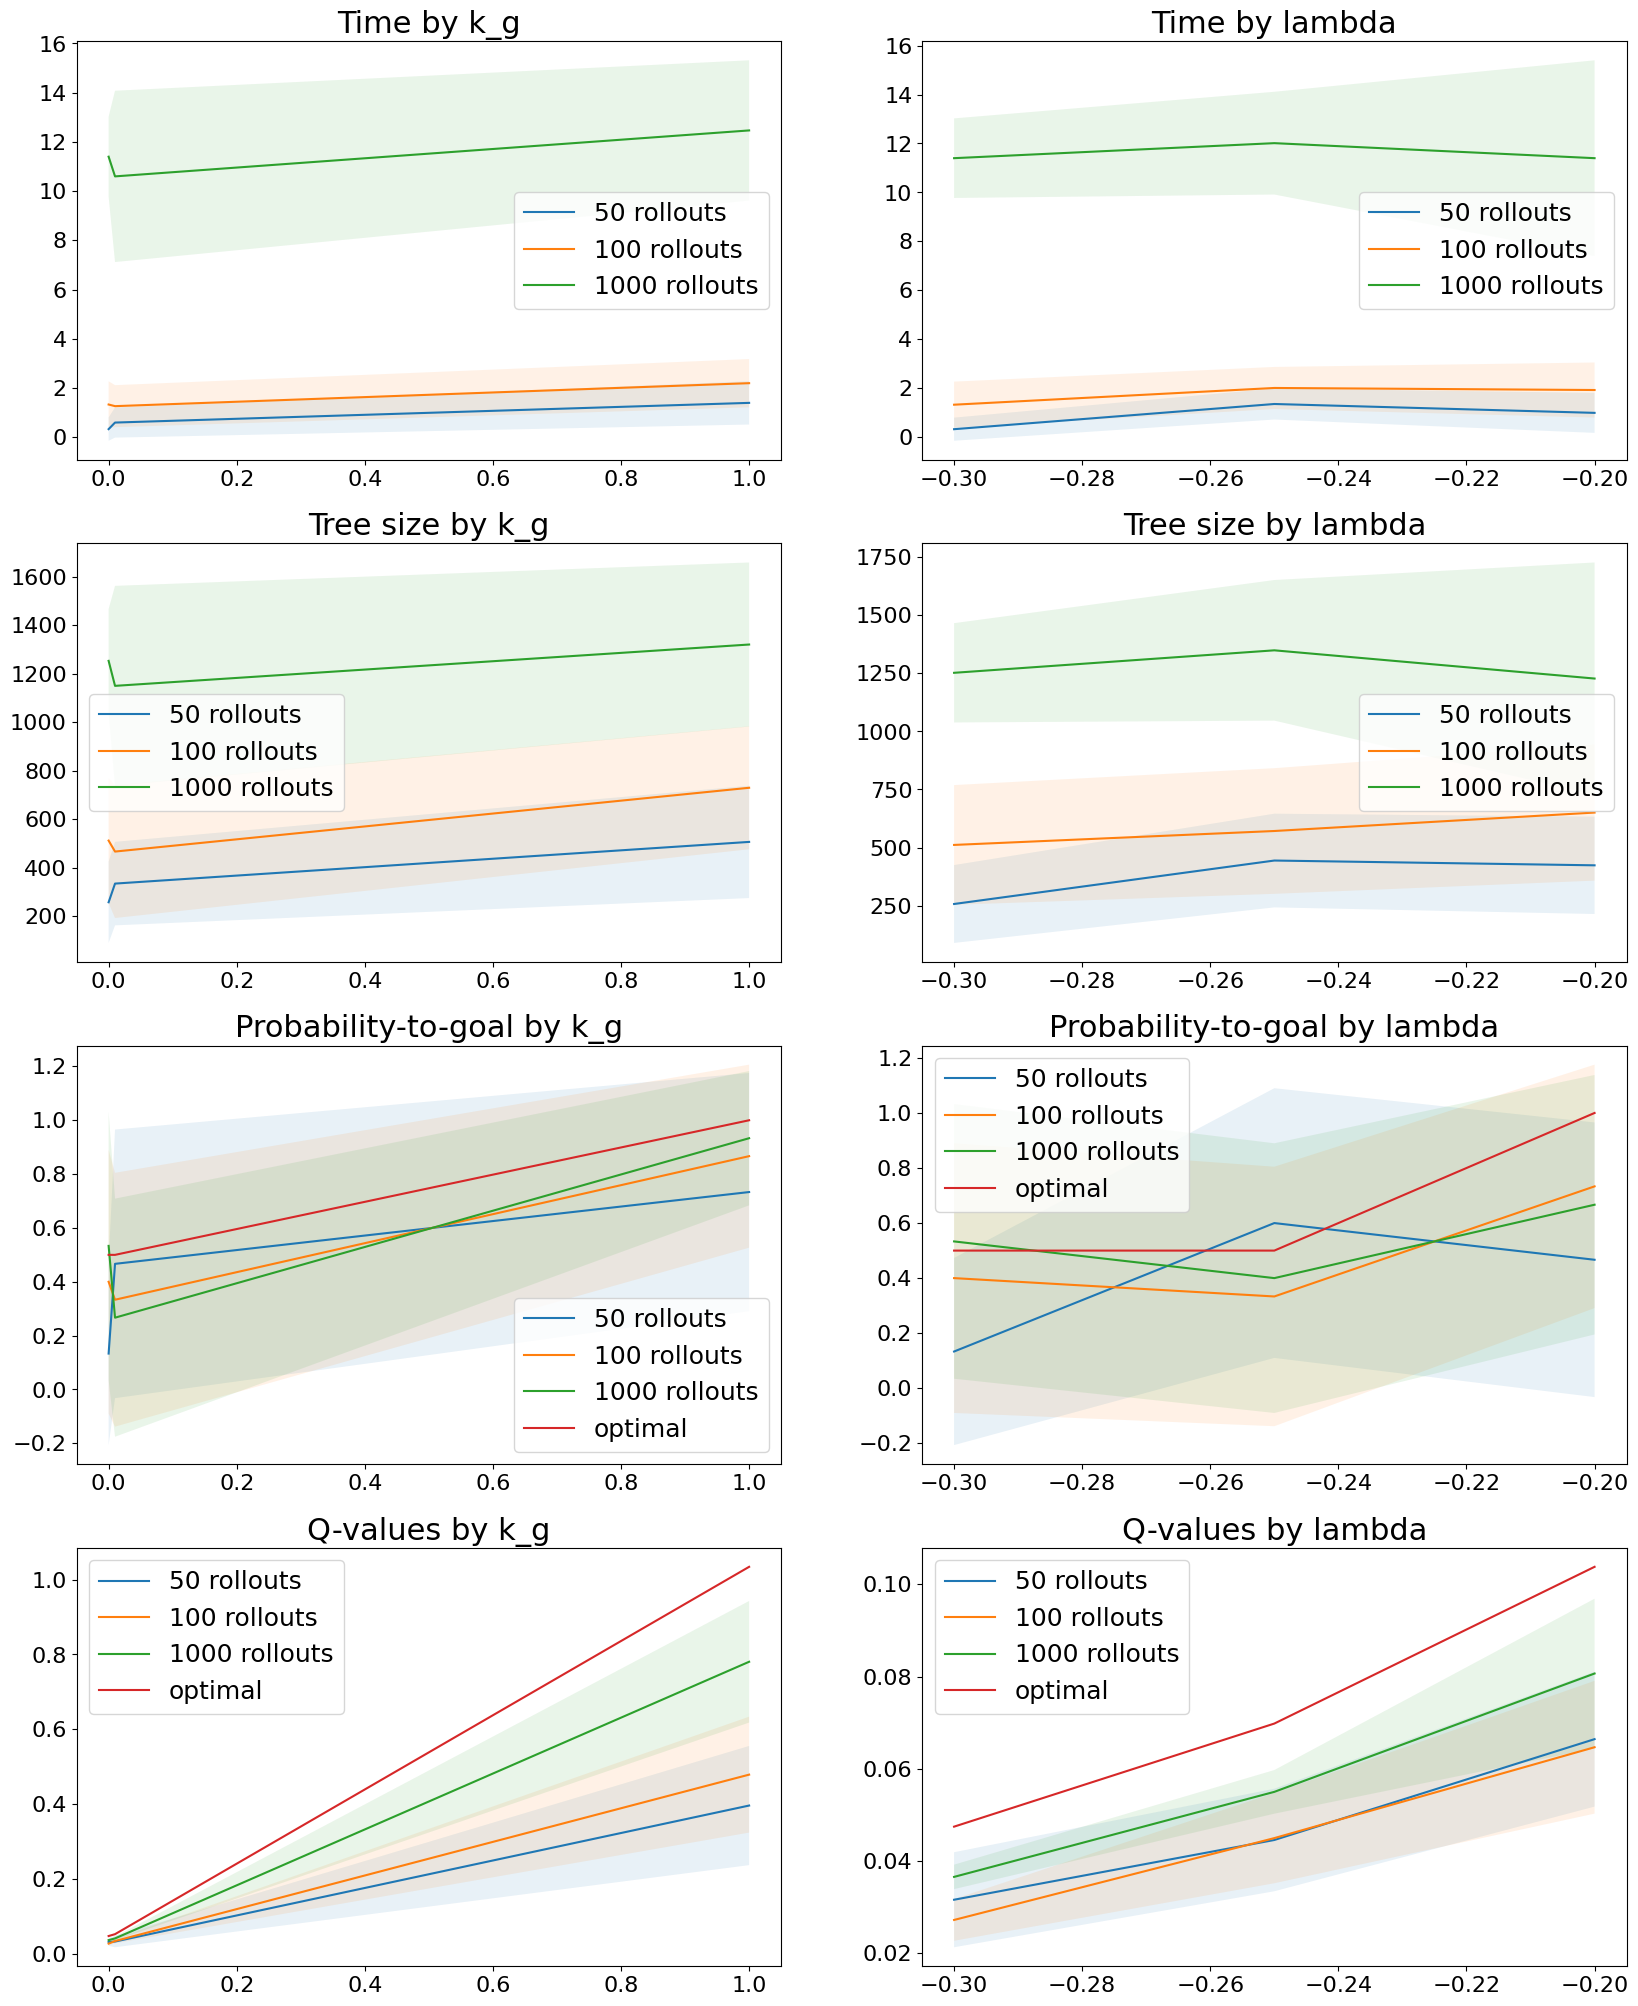

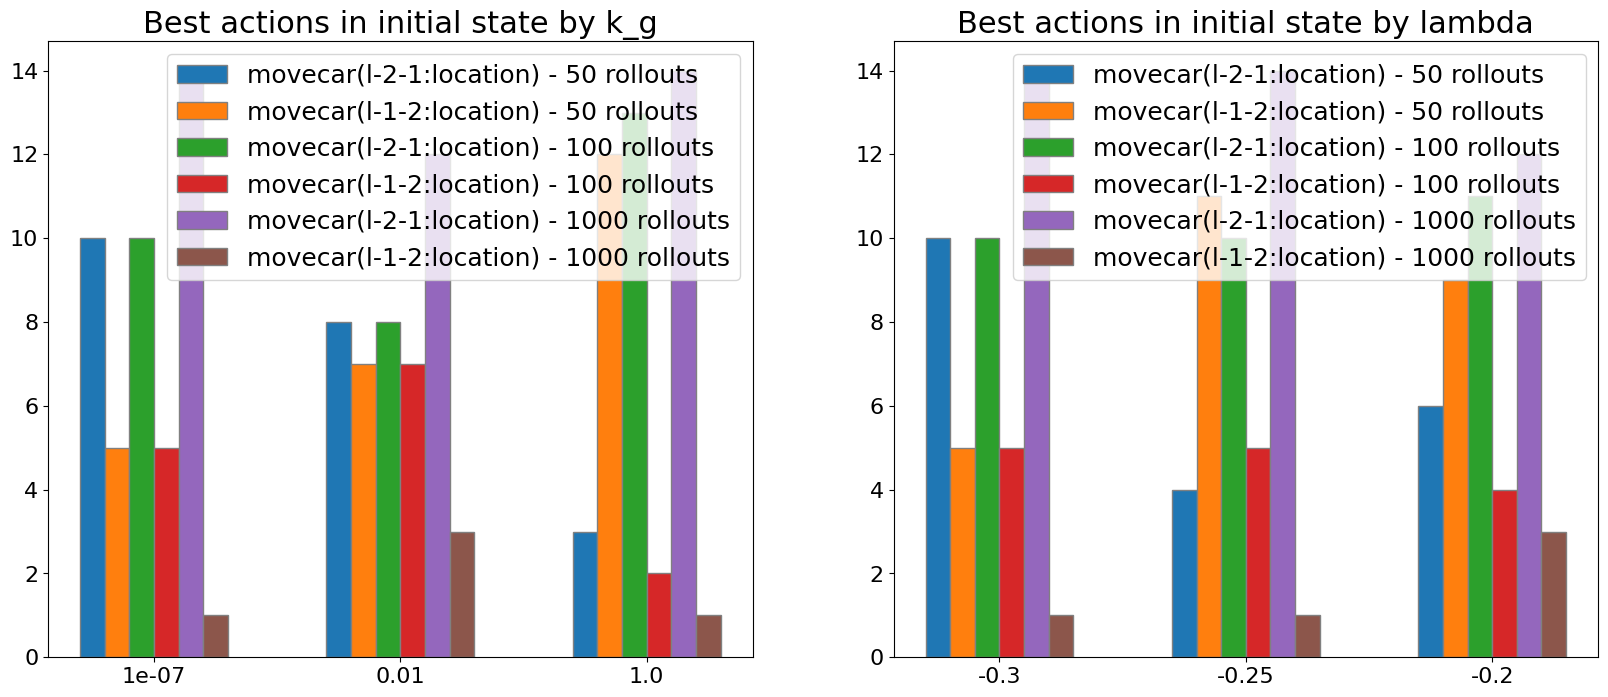

In [29]:
labels = ["50 rollouts", "100 rollouts", "1000 rollouts", "optimal"]

# Time
sources_lambda_fixed_time = [
   (n_rollouts_50_runs_by_kg_kgs, n_rollouts_50_runs_by_kg_time_mean, n_rollouts_50_runs_by_kg_time_std),
    (n_rollouts_100_runs_by_kg_kgs, n_rollouts_100_runs_by_kg_time_mean, n_rollouts_100_runs_by_kg_time_std),
    (n_rollouts_1000_runs_by_kg_kgs, n_rollouts_1000_runs_by_kg_time_mean, n_rollouts_1000_runs_by_kg_time_std),
]

sources_kg_fixed_time = [
    (n_rollouts_50_runs_by_lamb_kgs, n_rollouts_50_runs_by_lamb_time_mean, n_rollouts_50_runs_by_lamb_time_std),
    (n_rollouts_100_runs_by_lamb_kgs, n_rollouts_100_runs_by_lamb_time_mean, n_rollouts_100_runs_by_lamb_time_std),
    (n_rollouts_1000_runs_by_lamb_kgs, n_rollouts_1000_runs_by_lamb_time_mean, n_rollouts_1000_runs_by_lamb_time_std),
]

# Tree size
sources_lambda_fixed_size = [
    (n_rollouts_50_runs_by_kg_kgs, n_rollouts_50_runs_by_kg_size, n_rollouts_50_runs_by_kg_size_std),
    (n_rollouts_100_runs_by_kg_kgs, n_rollouts_100_runs_by_kg_size, n_rollouts_100_runs_by_kg_size_std),
    (n_rollouts_1000_runs_by_kg_kgs, n_rollouts_1000_runs_by_kg_size, n_rollouts_1000_runs_by_kg_size_std)
]

sources_kg_fixed_size = [
    (n_rollouts_50_runs_by_lamb_kgs, n_rollouts_50_runs_by_lamb_size, n_rollouts_50_runs_by_lamb_size_std),
    (n_rollouts_100_runs_by_lamb_kgs, n_rollouts_100_runs_by_lamb_size, n_rollouts_100_runs_by_lamb_size_std),
    (n_rollouts_1000_runs_by_lamb_kgs, n_rollouts_1000_runs_by_lamb_size, n_rollouts_1000_runs_by_lamb_size_std)
]

# Probability-to-goal
sources_lambda_fixed_probs = [
    (n_rollouts_50_runs_by_kg_kgs, n_rollouts_50_runs_by_kg_pg, n_rollouts_50_runs_by_kg_pg_std),
    (n_rollouts_100_runs_by_kg_kgs, n_rollouts_100_runs_by_kg_pg, n_rollouts_100_runs_by_kg_pg_std),
    (n_rollouts_1000_runs_by_kg_kgs, n_rollouts_1000_runs_by_kg_pg, n_rollouts_1000_runs_by_kg_pg_std),
    (n_rollouts_1000_runs_by_kg_kgs, lamb_opt_probs)
]

sources_kg_fixed_probs = [
    (n_rollouts_50_runs_by_lamb_kgs, n_rollouts_50_runs_by_lamb_pg, n_rollouts_50_runs_by_lamb_pg_std),
    (n_rollouts_100_runs_by_lamb_kgs, n_rollouts_100_runs_by_lamb_pg, n_rollouts_100_runs_by_lamb_pg_std),
    (n_rollouts_1000_runs_by_lamb_kgs, n_rollouts_1000_runs_by_lamb_pg, n_rollouts_1000_runs_by_lamb_pg_std),
    (n_rollouts_1000_runs_by_lamb_kgs, kg_opt_probs)
]


# Q-values
sources_lambda_fixed_qs = [
   (n_rollouts_50_runs_by_kg_kgs, n_rollouts_50_runs_by_kg_qs, n_rollouts_50_runs_by_kg_qs_std),
    (n_rollouts_100_runs_by_kg_kgs, n_rollouts_100_runs_by_kg_qs, n_rollouts_100_runs_by_kg_qs_std),
    (n_rollouts_1000_runs_by_kg_kgs, n_rollouts_1000_runs_by_kg_qs, n_rollouts_1000_runs_by_kg_qs_std),
    (n_rollouts_1000_runs_by_kg_kgs, lamb_opt_qs)
]

sources_kg_fixed_qs = [
    (n_rollouts_50_runs_by_lamb_kgs, n_rollouts_50_runs_by_lamb_qs, n_rollouts_50_runs_by_lamb_qs_std),
    (n_rollouts_100_runs_by_lamb_kgs, n_rollouts_100_runs_by_lamb_qs, n_rollouts_100_runs_by_lamb_qs_std),
    (n_rollouts_1000_runs_by_lamb_kgs, n_rollouts_1000_runs_by_lamb_qs, n_rollouts_1000_runs_by_lamb_qs_std),
    (n_rollouts_1000_runs_by_lamb_kgs, kg_opt_qs)
]

titles = [
    ["Time by k_g", "Time by lambda"],
    ["Tree size by k_g", "Tree size by lambda"],
    ["Probability-to-goal by k_g", "Probability-to-goal by lambda"],
    ["Q-values by k_g", "Q-values by lambda"]
]

plot_multiple_from_plot_data_source_sets([
    [sources_lambda_fixed_time, sources_kg_fixed_time],
    [sources_lambda_fixed_size, sources_kg_fixed_size],
    [sources_lambda_fixed_probs, sources_kg_fixed_probs],
    [sources_lambda_fixed_qs, sources_kg_fixed_qs]
], titles, labels, (4, 2), (20, 25))

labels = [
    'movecar(l-2-1:location) - 50 rollouts', 'movecar(l-1-2:location) - 50 rollouts',
    'movecar(l-2-1:location) - 100 rollouts', 'movecar(l-1-2:location) - 100 rollouts',
    'movecar(l-2-1:location) - 1000 rollouts', 'movecar(l-1-2:location) - 1000 rollouts'
]
titles = [["Best actions in initial state by k_g", "Best actions in initial state by lambda"]]

sources_kg_best_actions = [
    (norm_runs_by_kg_kgs, n_rollouts_50_runs_best_actions_s0_by_kg + n_rollouts_100_runs_best_actions_s0_by_kg + n_rollouts_1000_runs_best_actions_s0_by_kg),
]

sources_lamb_best_actions = [
    (norm_runs_by_lamb_lambs, n_rollouts_50_runs_best_actions_s0_by_lamb + n_rollouts_100_runs_best_actions_s0_by_lamb + n_rollouts_1000_runs_best_actions_s0_by_lamb),
]

# pprint(sources_kg_best_actions)
plot_multiple_from_plot_data_source_sets(
    [[sources_kg_best_actions, sources_lamb_best_actions]],
    titles, [labels, labels], (1, 2), (20, 8), bar_width=0.1, plot_type="bar"
)